# MPC EXPRESSION ANALYSIS NOTEBOOK  
Paper: Regulation of Tumor Initiation by the Mitochondrial Pyruvate Carrier   
Paper Authors: Claire L. Bensard and Dona R. Wisidigama, et. al.   

Analysis performed within the scope of this notebook by Jordan A. Berg and Alex J. Bott   
Description: The following notebook contains the code required to replicate specified plots and supplements

## Import Dependencies

In [1]:
import os
import re
import pandas as pd 
import xpressplot as xp
from scipy import stats
from math import sqrt
from statistics import mean, stdev
from sklearn import preprocessing
from statsmodels.stats.multitest import multipletests
import GEOparse
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

#Some microarray data was also processed using Alt Analyze (http://www.altanalyze.org/)

#Set path to this directory for accessing and saving files
__path__  = os.getcwd() + '/'

## Import Human Microarray Dataset GSE8671
The GEO-accessible data is not normalized. We therefore used Alt Analyze (http://www.altanalyze.org/) to RMA normalize probe signal.

In [2]:
#Get data
df_GSE8671 = xp.get_df(__path__ + 'data/GSE8671_rma_normalized.csv', delimiter=',') #RMA normalized with Alt Analyze
info_GSE8671 = xp.get_info(__path__ + "data/sample_info_gse8671.csv", delimiter=',')
df_GSE8671_c = xp.keep_labels(df_GSE8671, info_GSE8671, label_list=['Normal','Adenoma'])
df_GSE8671_clean = xp.clean_df(df_GSE8671_c)

#Collapse multi-mapping probes
df_GSE8671_collapsed = xp.probe_collapse(df_GSE8671_clean, __path__ + "data/GPL570.txt")
df_GSE8671_collapsed.to_csv(__path__ + "data/collapsed_GSE8671.csv",sep=',')

#Scale dataset
df_GSE8671_scaled, df_GSE8671_labeled = xp.prep_data(df_GSE8671_collapsed, info_GSE8671)

#sort by sample labels
info_GSE8671_sorted = info_GSE8671.copy()
info_GSE8671_sorted = info_GSE8671_sorted.loc[info_GSE8671_sorted[1].isin(['Adenoma', 'Normal'])]
info_GSE8671_sorted = info_GSE8671_sorted.sort_values([1], ascending=False)
info_GSE8671_sorted_list = info_GSE8671_sorted[0].tolist()
df_GSE8671_scaled_sorted = df_GSE8671_scaled[info_GSE8671_sorted_list]

#set palette
gse8671_colors = {'Adenoma': (0.8705882352941177, 0.5607843137254902, 0.0196078431372549),
        'Normal': (0.00784313725490196, 0.6196078431372549, 0.45098039215686275)}

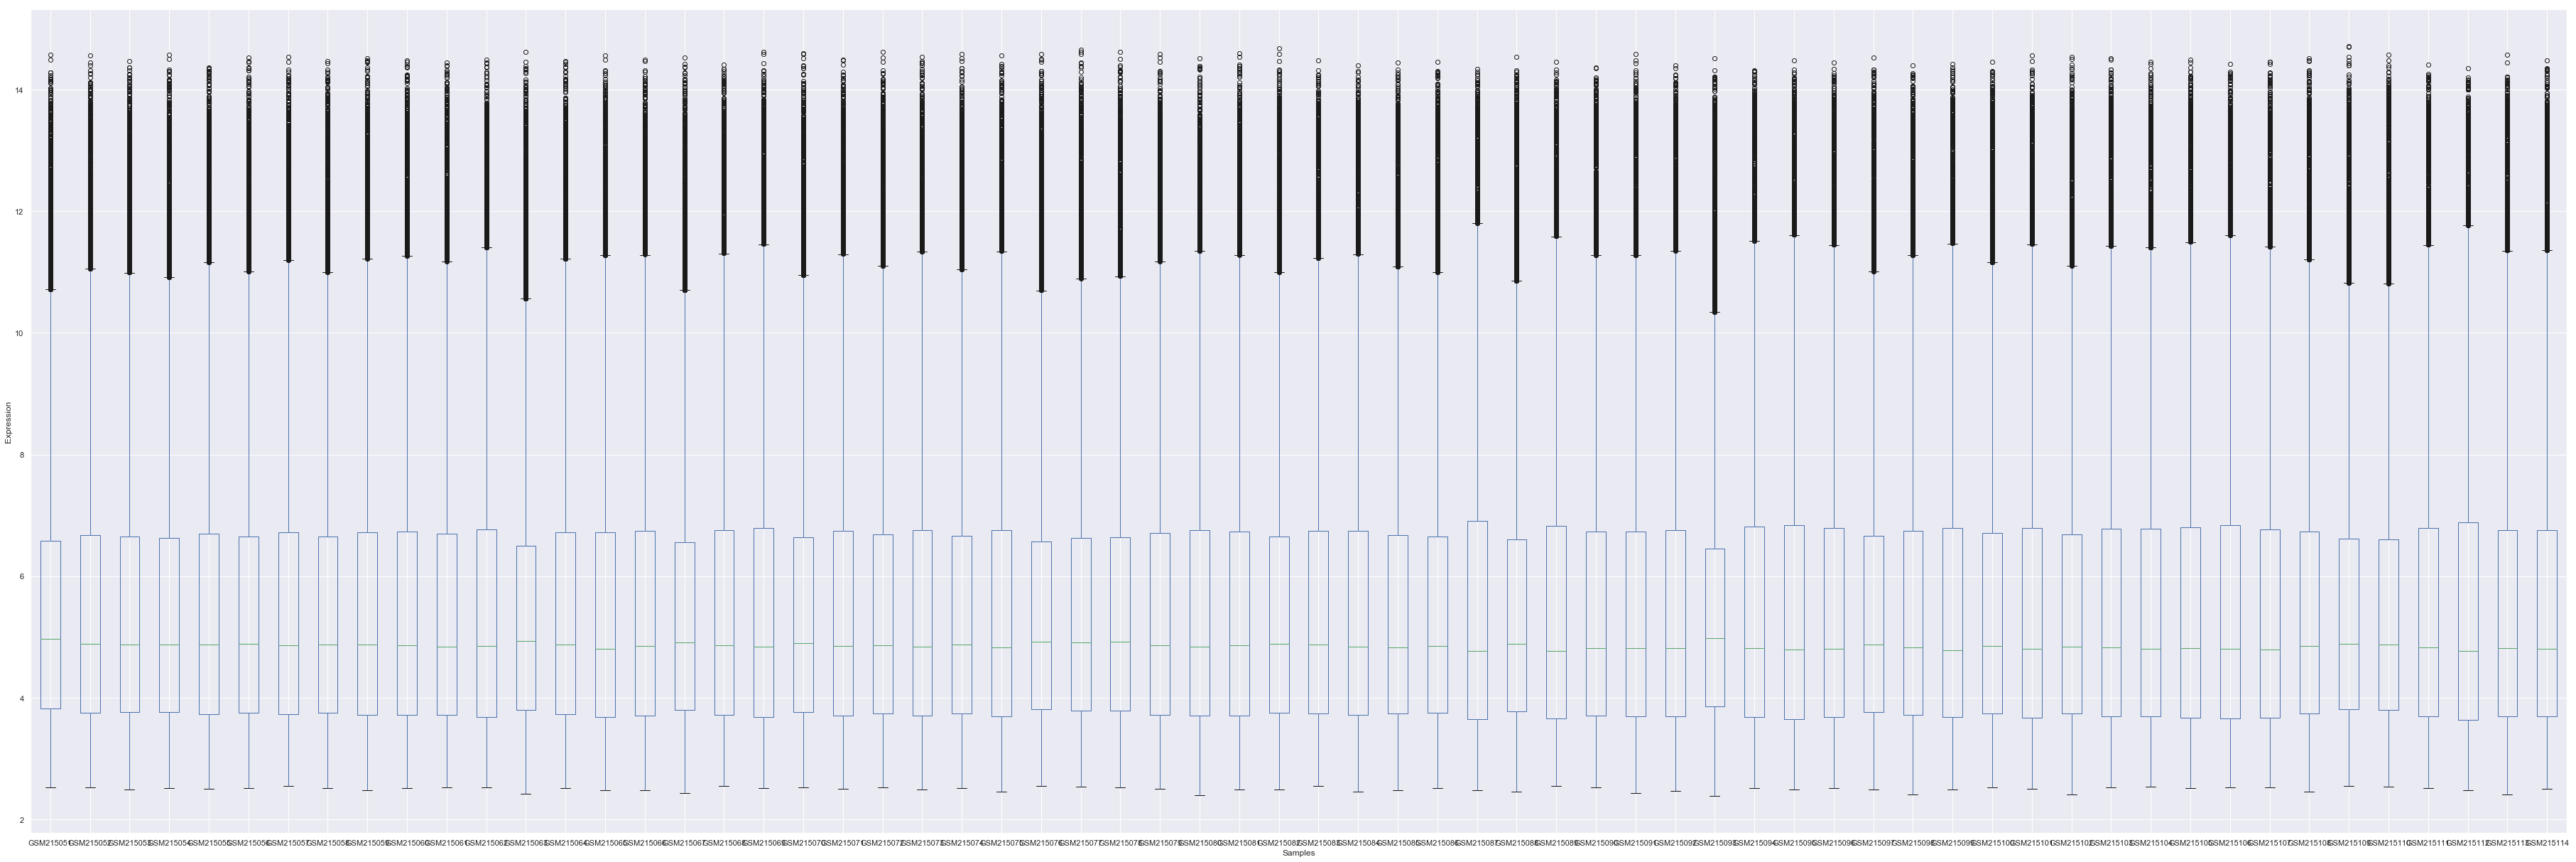

In [3]:
xp.check_samples(df_GSE8671_clean)

## Import Human Microarray Dataset GSE20916

In [4]:
def get_geo(
    geo_id,
    output_info=False, output_path="./"):

    # Get data
    gse = GEOparse.get_GEO(geo=str(geo_id).upper(), destdir=output_path) # Import GSE dataset

    data = gse.pivot_samples('VALUE')
    data = xp.clean_df(data)

    # Get metadata
    # Write data to output file
    if output_info != False:
        with open(str(geo_id).upper() + '.txt', 'w+') as f: # Save all information as text file for reference
            for gsm_name, gsm in gse.gsms.items():
                f.write(gsm_name + '\n')
                for key, value in gsm.metadata.items():
                    f.write(" - %s : %s" % (key, ", ".join(value)) + '\n')

    # Populate metadata with sample ids and names
    metadata = pd.DataFrame(columns=['gsm', 'title']) # Create dataframe
    gsm_list, title_list, data_processing_list = [], [], []
    for gsm_name, gsm in gse.gsms.items():
        for key, value in gsm.metadata.items():
            if key == 'title':
                title_list.append(''.join(value))
            if key == 'geo_accession':
                gsm_list.append(''.join(value))
            if key == 'data_processing':
                data_processing_list.append(''.join(value))

    metadata['gsm'], metadata['title'] = gsm_list, title_list
    metadata.columns = range(metadata.shape[1])

    # Output processing style
    print('Data processing summary:\n' + str(set(data_processing_list))) # To determine if all samples have undergone the sample data processing

    # Clean data
    del data.columns.name
    del data.index.name

    # Clean metadata
    metadata[1] = metadata[1].apply(lambda x: x[0:(re.search("\d", x).start()) - 1])

    return data, metadata

# Get data from GEO database 
#df_GSE20916, info_GSE20916 = get_geo('GSE20916')

#df_GSE20916.to_csv(__path__ + "data/GSE20916_normalized.csv", sep=',')
#info_GSE20916.to_csv(__path__ + "data/sample_info_gse20916.csv", sep=',', index=False)

In [5]:
#Get data
df_GSE20916 = pd.read_csv(__path__ + "data/GSE20916_normalized.csv", index_col=0)
info_GSE20916 = pd.read_csv(__path__ + "data/sample_info_gse20916.csv")
info_GSE20916.columns = [0,1]
info_GSE20916[1] = info_GSE20916[1].str.capitalize() #Make sample types look nice
info_GSE20916 = info_GSE20916.replace('Normal_colon', 'Normal')
df_GSE20916_c = xp.keep_labels(df_GSE20916, info_GSE20916, label_list=['Normal','Adenoma','Adenocarcinoma'])
df_GSE20916_clean = xp.clean_df(df_GSE20916_c)

#Collapse multi-mapping probes
df_GSE20916_collapsed = xp.probe_collapse(df_GSE20916_clean, __path__ + "data/GPL570.txt")
df_GSE20916_collapsed.to_csv(__path__ + "data/collapsed_GSE20916.txt",sep='\t')

#Scale sorted dataset
df_GSE20916_scaled, df_GSE20916_labeled = xp.prep_data(df_GSE20916_collapsed, info_GSE20916)

#sort by sample labels
info_GSE20916_sorted = info_GSE20916.copy()
info_GSE20916_sorted = info_GSE20916_sorted.loc[info_GSE20916_sorted[1].isin(['Adenoma', 'Adenocarcinoma','Normal'])]
info_GSE20916_sorted = info_GSE20916_sorted.sort_values([1], ascending=False)
info_GSE20916_sorted_list = info_GSE20916_sorted[0].tolist()
df_GSE20916_scaled_sorted = df_GSE20916_scaled[info_GSE20916_sorted_list]

#Drop Adenocarcinomas
df_GSE20916_collapsed_noac = xp.drop_label(df_GSE20916_collapsed, info_GSE20916, 'Adenocarcinoma')

gse20916_colors = {'Adenocarcinoma': (0.5725490196078431, 0.5843137254901961, 0.5686274509803921),
        'Adenoma': (0.8705882352941177, 0.5607843137254902, 0.0196078431372549),
        'Normal': (0.00784313725490196, 0.6196078431372549, 0.45098039215686275)}

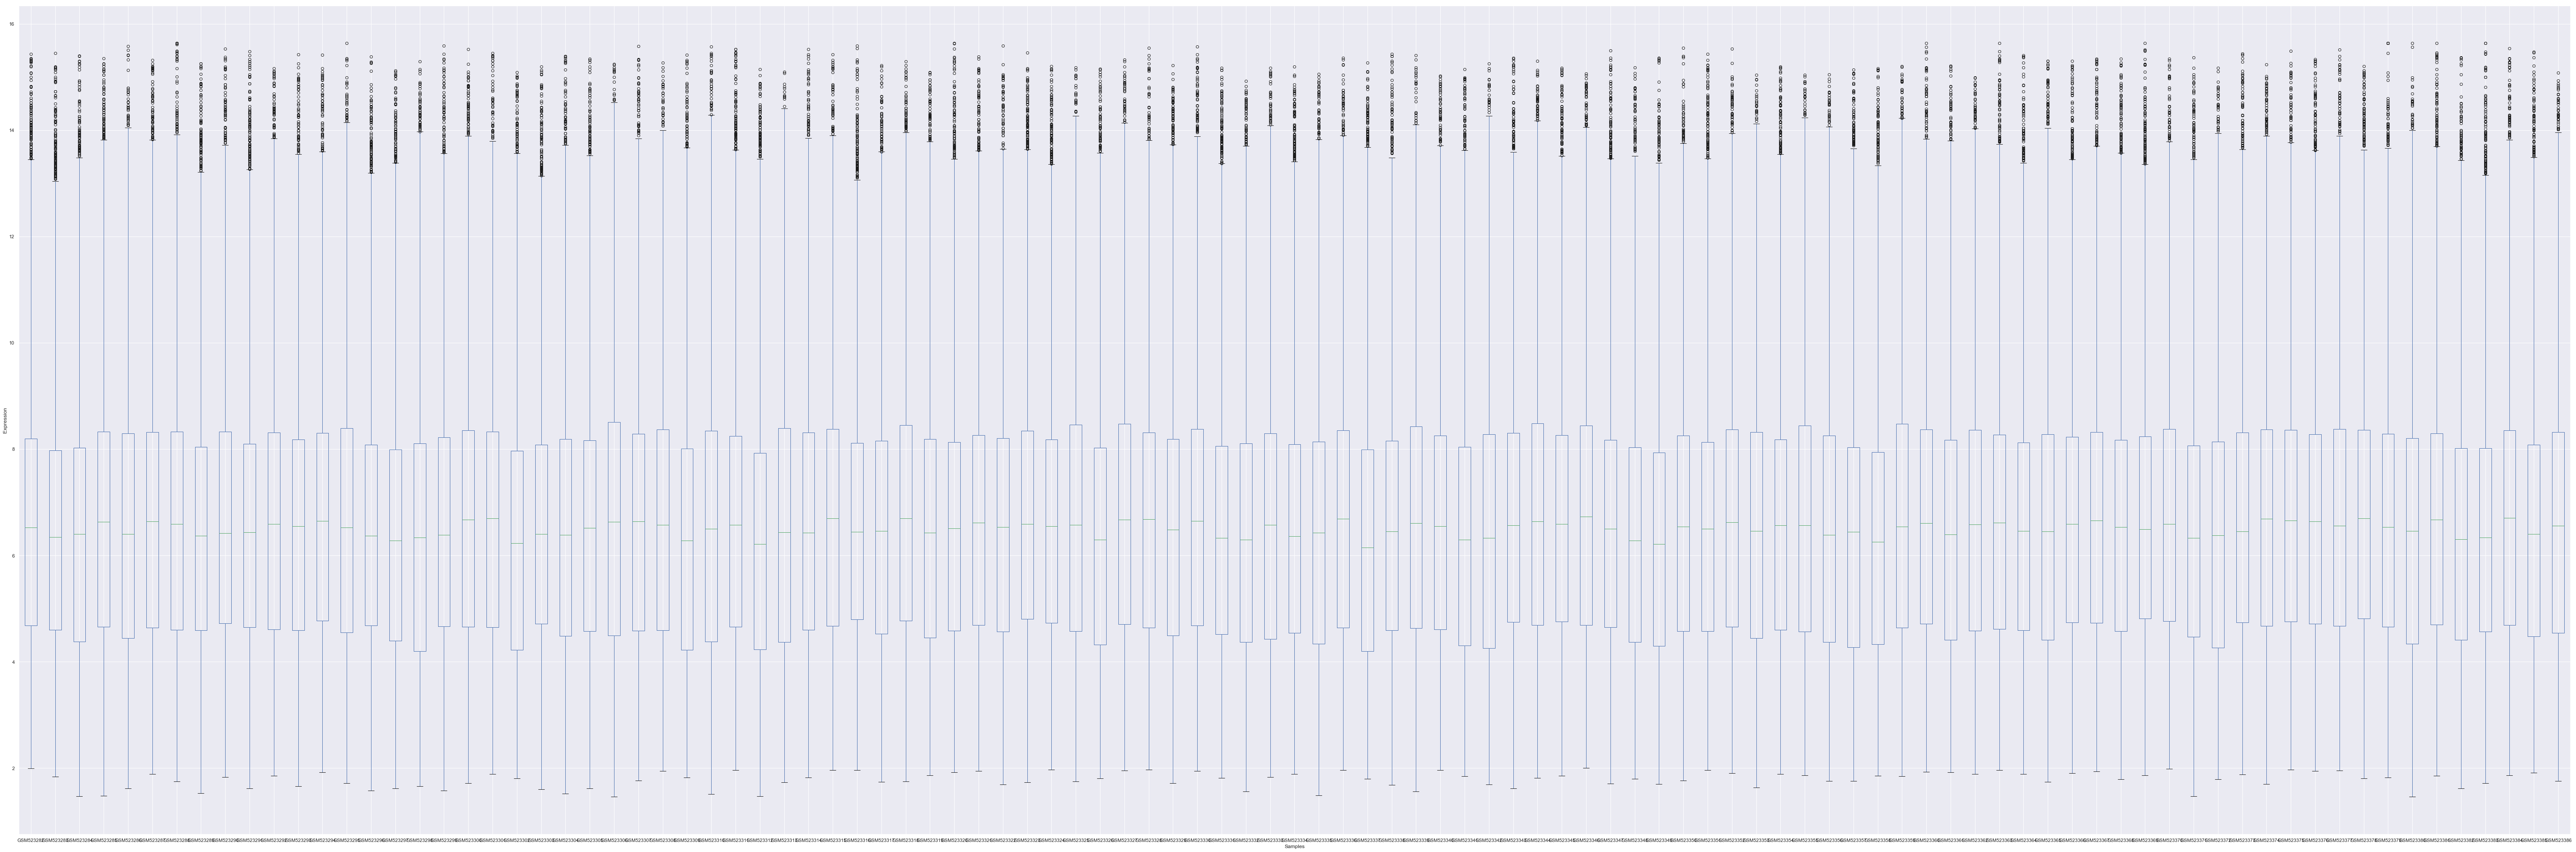

In [6]:
xp.check_samples(df_GSE20916_clean)

## Import Mouse APC Data

In [7]:
apc_df = pd.read_csv(__path__ + "data/custom_apc_normalized.csv", sep=",", index_col=0, low_memory=False)
apc_info = xp.get_info(__path__ + "data/apc_info.csv", delimiter=',')
apc_clean = xp.clean_df(apc_df)
apc_scaled, apc_labeled = xp.prep_data(apc_clean, apc_info)

apc_colors = {'APC-KO': (0.00392156862745098, 0.45098039215686275, 0.6980392156862745),
         'APC-WT': (0.8705882352941177, 0.5607843137254902, 0.0196078431372549),
         'Normal-KO': (0.8352941176470589, 0.3686274509803922, 0.0),
         'Normal-WT': (0.00784313725490196, 0.6196078431372549, 0.45098039215686275)}

## Import Mouse AOMDSS Data

In [8]:
aomdss_df = pd.read_csv(__path__ + "data/custom_aomdss_normalized.csv", sep=",", index_col=0, low_memory=False)
aomdss_info = xp.get_info(__path__ + "data/aomdss_info.csv", delimiter=',')
aomdss_clean = xp.clean_df(aomdss_df)
aomdss_scaled, aomdss_labeled = xp.prep_data(aomdss_clean, aomdss_info)

aomdss_colors = {'AOMDSS-KO': (0.00392156862745098, 0.45098039215686275, 0.6980392156862745),
         'AOMDSS-WT': (0.8705882352941177, 0.5607843137254902, 0.0196078431372549),
         'Normal-KO': (0.8352941176470589, 0.3686274509803922, 0.0),
         'Normal-WT': (0.00784313725490196, 0.6196078431372549, 0.45098039215686275)}

## Establish Gene Sets to Survey

In [9]:
with open(__path__ + "data/custom22.csv", 'r') as f:
    for line in f:
        custom22_mouse = line.split(",")
custom22_human = [x.upper() for x in custom22_mouse]

stem_genes = ['Ctnnb1','Notch1','Ascl2','Myc','Hopx','Sox9','Lgr5','Lef1','Mmp7','Axin2','Cd44','Ccnd1','Bmi1','Tert']
diff_genes = ['Fabp2','Atoh1','Muc2','Krt20','Chga','Vil1','MPC1','MPC2']

pyru = pd.read_csv('data/custom_pyruvate_list.csv',header=None)
pyru_list = pyru[0].tolist()

In [10]:
# Display number of missing genes from the microarray datasets from the gene list

print('Total pyruvate-related genes:',len(pyru_list))
print('Total in GSE8671:', df_GSE8671_labeled.reindex(pyru_list).dropna().shape[0])
print('Total in GSE20916:', df_GSE20916_labeled.reindex(pyru_list).dropna().shape[0])

Total pyruvate-related genes: 80
Total in GSE8671: 75
Total in GSE20916: 60


In [11]:
GSE8671_pyru = df_GSE8671_labeled.reindex(pyru_list)
GSE8671_pyru.to_csv('./data/GSE8671_pyruvate_list.csv')

In [12]:
GSE20916_pyru = df_GSE20916_labeled.reindex(pyru_list)
GSE20916_pyru.to_csv('./data/GSE20916_pyruvate_list.csv')

## LDH and MPC Expression with Stats

<Figure size 432x288 with 0 Axes>

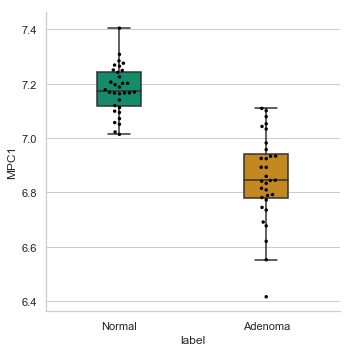

In [13]:
"""
LDH and MPC Relationship in Human Dataset GSE8671
"""
xp.gene_overview(df_GSE8671_labeled, info_GSE8671, gene_name='MPC1',palette=gse8671_colors, 
                  order=['Normal','Adenoma'], grid=True, whitegrid=True,
                 save_fig=__path__ + 'plots/MPC1_boxswarm_GSE8671.pdf')

<Figure size 432x288 with 0 Axes>

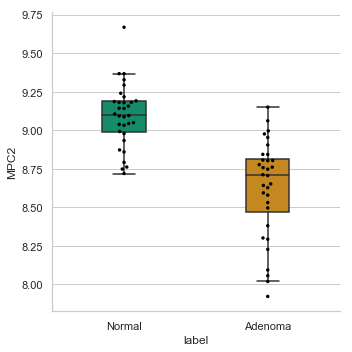

In [14]:
xp.gene_overview(df_GSE8671_labeled, info_GSE8671, gene_name='MPC2',palette=gse8671_colors, 
                  order=['Normal','Adenoma'],
                 save_fig=__path__ + 'plots/MPC2_boxswarm_GSE8671.pdf', grid=True, whitegrid=True)

<Figure size 432x288 with 0 Axes>

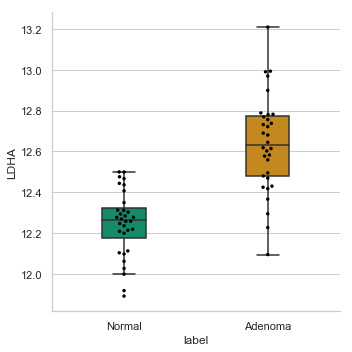

In [15]:
xp.gene_overview(df_GSE8671_labeled, info_GSE8671, gene_name='LDHA',palette=gse8671_colors, 
                  order=['Normal','Adenoma'],
                 save_fig=__path__ + 'plots/LDHA_boxswarm_GSE8671.pdf', grid=True, whitegrid=True)

<Figure size 432x288 with 0 Axes>

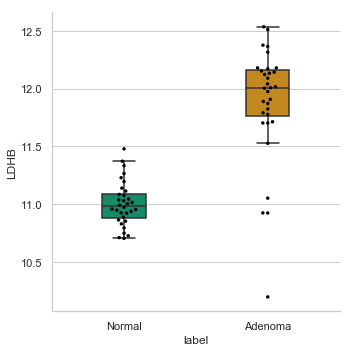

In [16]:
xp.gene_overview(df_GSE8671_labeled, info_GSE8671, gene_name='LDHB',palette=gse8671_colors, 
                  order=['Normal','Adenoma'],
                 save_fig=__path__ + 'plots/LDHB_boxswarm_GSE8671.pdf', grid=True, whitegrid=True)

In [17]:
#Statistical tests
GSE8671_stats = df_GSE8671_labeled.copy()
GSE8671_norm = GSE8671_stats[info_GSE8671.loc[info_GSE8671[1] == 'Normal'][0].tolist()]
GSE8671_ad = GSE8671_stats[info_GSE8671.loc[info_GSE8671[1] == 'Adenoma'][0].tolist()]

p_vals = []
genes = GSE8671_stats.index.tolist()

total = len(genes) - 1
counter = 1

for x in genes[1:]:
    s, p = stats.ranksums(xp.get_array(GSE8671_norm, str(x)), xp.get_array(GSE8671_ad, str(x)))
    p_vals.append(p) 
    print(counter,'/',total)
    counter += 1

fdr = multipletests(p_vals, alpha=0.05, method='fdr_bh')

sig_data = pd.DataFrame()
sig_data[0] = p_vals 
sig_data[1] = fdr[1]
sig_data.index = genes[1:]

1 / 21655
2 / 21655
3 / 21655
4 / 21655
5 / 21655
6 / 21655
7 / 21655
8 / 21655
9 / 21655
10 / 21655
11 / 21655
12 / 21655
13 / 21655
14 / 21655
15 / 21655
16 / 21655
17 / 21655
18 / 21655
19 / 21655
20 / 21655
21 / 21655
22 / 21655
23 / 21655
24 / 21655
25 / 21655
26 / 21655
27 / 21655
28 / 21655
29 / 21655
30 / 21655
31 / 21655
32 / 21655
33 / 21655
34 / 21655
35 / 21655
36 / 21655
37 / 21655
38 / 21655
39 / 21655
40 / 21655
41 / 21655
42 / 21655
43 / 21655
44 / 21655
45 / 21655
46 / 21655
47 / 21655
48 / 21655
49 / 21655
50 / 21655
51 / 21655
52 / 21655
53 / 21655
54 / 21655
55 / 21655
56 / 21655
57 / 21655
58 / 21655
59 / 21655
60 / 21655
61 / 21655
62 / 21655
63 / 21655
64 / 21655
65 / 21655
66 / 21655
67 / 21655
68 / 21655
69 / 21655
70 / 21655
71 / 21655
72 / 21655
73 / 21655
74 / 21655
75 / 21655
76 / 21655
77 / 21655
78 / 21655
79 / 21655
80 / 21655
81 / 21655
82 / 21655
83 / 21655
84 / 21655
85 / 21655
86 / 21655
87 / 21655
88 / 21655
89 / 21655
90 / 21655
91 / 21655
92 / 216

701 / 21655
702 / 21655
703 / 21655
704 / 21655
705 / 21655
706 / 21655
707 / 21655
708 / 21655
709 / 21655
710 / 21655
711 / 21655
712 / 21655
713 / 21655
714 / 21655
715 / 21655
716 / 21655
717 / 21655
718 / 21655
719 / 21655
720 / 21655
721 / 21655
722 / 21655
723 / 21655
724 / 21655
725 / 21655
726 / 21655
727 / 21655
728 / 21655
729 / 21655
730 / 21655
731 / 21655
732 / 21655
733 / 21655
734 / 21655
735 / 21655
736 / 21655
737 / 21655
738 / 21655
739 / 21655
740 / 21655
741 / 21655
742 / 21655
743 / 21655
744 / 21655
745 / 21655
746 / 21655
747 / 21655
748 / 21655
749 / 21655
750 / 21655
751 / 21655
752 / 21655
753 / 21655
754 / 21655
755 / 21655
756 / 21655
757 / 21655
758 / 21655
759 / 21655
760 / 21655
761 / 21655
762 / 21655
763 / 21655
764 / 21655
765 / 21655
766 / 21655
767 / 21655
768 / 21655
769 / 21655
770 / 21655
771 / 21655
772 / 21655
773 / 21655
774 / 21655
775 / 21655
776 / 21655
777 / 21655
778 / 21655
779 / 21655
780 / 21655
781 / 21655
782 / 21655
783 / 21655
784 

1369 / 21655
1370 / 21655
1371 / 21655
1372 / 21655
1373 / 21655
1374 / 21655
1375 / 21655
1376 / 21655
1377 / 21655
1378 / 21655
1379 / 21655
1380 / 21655
1381 / 21655
1382 / 21655
1383 / 21655
1384 / 21655
1385 / 21655
1386 / 21655
1387 / 21655
1388 / 21655
1389 / 21655
1390 / 21655
1391 / 21655
1392 / 21655
1393 / 21655
1394 / 21655
1395 / 21655
1396 / 21655
1397 / 21655
1398 / 21655
1399 / 21655
1400 / 21655
1401 / 21655
1402 / 21655
1403 / 21655
1404 / 21655
1405 / 21655
1406 / 21655
1407 / 21655
1408 / 21655
1409 / 21655
1410 / 21655
1411 / 21655
1412 / 21655
1413 / 21655
1414 / 21655
1415 / 21655
1416 / 21655
1417 / 21655
1418 / 21655
1419 / 21655
1420 / 21655
1421 / 21655
1422 / 21655
1423 / 21655
1424 / 21655
1425 / 21655
1426 / 21655
1427 / 21655
1428 / 21655
1429 / 21655
1430 / 21655
1431 / 21655
1432 / 21655
1433 / 21655
1434 / 21655
1435 / 21655
1436 / 21655
1437 / 21655
1438 / 21655
1439 / 21655
1440 / 21655
1441 / 21655
1442 / 21655
1443 / 21655
1444 / 21655
1445 / 21655

2008 / 21655
2009 / 21655
2010 / 21655
2011 / 21655
2012 / 21655
2013 / 21655
2014 / 21655
2015 / 21655
2016 / 21655
2017 / 21655
2018 / 21655
2019 / 21655
2020 / 21655
2021 / 21655
2022 / 21655
2023 / 21655
2024 / 21655
2025 / 21655
2026 / 21655
2027 / 21655
2028 / 21655
2029 / 21655
2030 / 21655
2031 / 21655
2032 / 21655
2033 / 21655
2034 / 21655
2035 / 21655
2036 / 21655
2037 / 21655
2038 / 21655
2039 / 21655
2040 / 21655
2041 / 21655
2042 / 21655
2043 / 21655
2044 / 21655
2045 / 21655
2046 / 21655
2047 / 21655
2048 / 21655
2049 / 21655
2050 / 21655
2051 / 21655
2052 / 21655
2053 / 21655
2054 / 21655
2055 / 21655
2056 / 21655
2057 / 21655
2058 / 21655
2059 / 21655
2060 / 21655
2061 / 21655
2062 / 21655
2063 / 21655
2064 / 21655
2065 / 21655
2066 / 21655
2067 / 21655
2068 / 21655
2069 / 21655
2070 / 21655
2071 / 21655
2072 / 21655
2073 / 21655
2074 / 21655
2075 / 21655
2076 / 21655
2077 / 21655
2078 / 21655
2079 / 21655
2080 / 21655
2081 / 21655
2082 / 21655
2083 / 21655
2084 / 21655

2653 / 21655
2654 / 21655
2655 / 21655
2656 / 21655
2657 / 21655
2658 / 21655
2659 / 21655
2660 / 21655
2661 / 21655
2662 / 21655
2663 / 21655
2664 / 21655
2665 / 21655
2666 / 21655
2667 / 21655
2668 / 21655
2669 / 21655
2670 / 21655
2671 / 21655
2672 / 21655
2673 / 21655
2674 / 21655
2675 / 21655
2676 / 21655
2677 / 21655
2678 / 21655
2679 / 21655
2680 / 21655
2681 / 21655
2682 / 21655
2683 / 21655
2684 / 21655
2685 / 21655
2686 / 21655
2687 / 21655
2688 / 21655
2689 / 21655
2690 / 21655
2691 / 21655
2692 / 21655
2693 / 21655
2694 / 21655
2695 / 21655
2696 / 21655
2697 / 21655
2698 / 21655
2699 / 21655
2700 / 21655
2701 / 21655
2702 / 21655
2703 / 21655
2704 / 21655
2705 / 21655
2706 / 21655
2707 / 21655
2708 / 21655
2709 / 21655
2710 / 21655
2711 / 21655
2712 / 21655
2713 / 21655
2714 / 21655
2715 / 21655
2716 / 21655
2717 / 21655
2718 / 21655
2719 / 21655
2720 / 21655
2721 / 21655
2722 / 21655
2723 / 21655
2724 / 21655
2725 / 21655
2726 / 21655
2727 / 21655
2728 / 21655
2729 / 21655

3294 / 21655
3295 / 21655
3296 / 21655
3297 / 21655
3298 / 21655
3299 / 21655
3300 / 21655
3301 / 21655
3302 / 21655
3303 / 21655
3304 / 21655
3305 / 21655
3306 / 21655
3307 / 21655
3308 / 21655
3309 / 21655
3310 / 21655
3311 / 21655
3312 / 21655
3313 / 21655
3314 / 21655
3315 / 21655
3316 / 21655
3317 / 21655
3318 / 21655
3319 / 21655
3320 / 21655
3321 / 21655
3322 / 21655
3323 / 21655
3324 / 21655
3325 / 21655
3326 / 21655
3327 / 21655
3328 / 21655
3329 / 21655
3330 / 21655
3331 / 21655
3332 / 21655
3333 / 21655
3334 / 21655
3335 / 21655
3336 / 21655
3337 / 21655
3338 / 21655
3339 / 21655
3340 / 21655
3341 / 21655
3342 / 21655
3343 / 21655
3344 / 21655
3345 / 21655
3346 / 21655
3347 / 21655
3348 / 21655
3349 / 21655
3350 / 21655
3351 / 21655
3352 / 21655
3353 / 21655
3354 / 21655
3355 / 21655
3356 / 21655
3357 / 21655
3358 / 21655
3359 / 21655
3360 / 21655
3361 / 21655
3362 / 21655
3363 / 21655
3364 / 21655
3365 / 21655
3366 / 21655
3367 / 21655
3368 / 21655
3369 / 21655
3370 / 21655

3938 / 21655
3939 / 21655
3940 / 21655
3941 / 21655
3942 / 21655
3943 / 21655
3944 / 21655
3945 / 21655
3946 / 21655
3947 / 21655
3948 / 21655
3949 / 21655
3950 / 21655
3951 / 21655
3952 / 21655
3953 / 21655
3954 / 21655
3955 / 21655
3956 / 21655
3957 / 21655
3958 / 21655
3959 / 21655
3960 / 21655
3961 / 21655
3962 / 21655
3963 / 21655
3964 / 21655
3965 / 21655
3966 / 21655
3967 / 21655
3968 / 21655
3969 / 21655
3970 / 21655
3971 / 21655
3972 / 21655
3973 / 21655
3974 / 21655
3975 / 21655
3976 / 21655
3977 / 21655
3978 / 21655
3979 / 21655
3980 / 21655
3981 / 21655
3982 / 21655
3983 / 21655
3984 / 21655
3985 / 21655
3986 / 21655
3987 / 21655
3988 / 21655
3989 / 21655
3990 / 21655
3991 / 21655
3992 / 21655
3993 / 21655
3994 / 21655
3995 / 21655
3996 / 21655
3997 / 21655
3998 / 21655
3999 / 21655
4000 / 21655
4001 / 21655
4002 / 21655
4003 / 21655
4004 / 21655
4005 / 21655
4006 / 21655
4007 / 21655
4008 / 21655
4009 / 21655
4010 / 21655
4011 / 21655
4012 / 21655
4013 / 21655
4014 / 21655

4571 / 21655
4572 / 21655
4573 / 21655
4574 / 21655
4575 / 21655
4576 / 21655
4577 / 21655
4578 / 21655
4579 / 21655
4580 / 21655
4581 / 21655
4582 / 21655
4583 / 21655
4584 / 21655
4585 / 21655
4586 / 21655
4587 / 21655
4588 / 21655
4589 / 21655
4590 / 21655
4591 / 21655
4592 / 21655
4593 / 21655
4594 / 21655
4595 / 21655
4596 / 21655
4597 / 21655
4598 / 21655
4599 / 21655
4600 / 21655
4601 / 21655
4602 / 21655
4603 / 21655
4604 / 21655
4605 / 21655
4606 / 21655
4607 / 21655
4608 / 21655
4609 / 21655
4610 / 21655
4611 / 21655
4612 / 21655
4613 / 21655
4614 / 21655
4615 / 21655
4616 / 21655
4617 / 21655
4618 / 21655
4619 / 21655
4620 / 21655
4621 / 21655
4622 / 21655
4623 / 21655
4624 / 21655
4625 / 21655
4626 / 21655
4627 / 21655
4628 / 21655
4629 / 21655
4630 / 21655
4631 / 21655
4632 / 21655
4633 / 21655
4634 / 21655
4635 / 21655
4636 / 21655
4637 / 21655
4638 / 21655
4639 / 21655
4640 / 21655
4641 / 21655
4642 / 21655
4643 / 21655
4644 / 21655
4645 / 21655
4646 / 21655
4647 / 21655

5203 / 21655
5204 / 21655
5205 / 21655
5206 / 21655
5207 / 21655
5208 / 21655
5209 / 21655
5210 / 21655
5211 / 21655
5212 / 21655
5213 / 21655
5214 / 21655
5215 / 21655
5216 / 21655
5217 / 21655
5218 / 21655
5219 / 21655
5220 / 21655
5221 / 21655
5222 / 21655
5223 / 21655
5224 / 21655
5225 / 21655
5226 / 21655
5227 / 21655
5228 / 21655
5229 / 21655
5230 / 21655
5231 / 21655
5232 / 21655
5233 / 21655
5234 / 21655
5235 / 21655
5236 / 21655
5237 / 21655
5238 / 21655
5239 / 21655
5240 / 21655
5241 / 21655
5242 / 21655
5243 / 21655
5244 / 21655
5245 / 21655
5246 / 21655
5247 / 21655
5248 / 21655
5249 / 21655
5250 / 21655
5251 / 21655
5252 / 21655
5253 / 21655
5254 / 21655
5255 / 21655
5256 / 21655
5257 / 21655
5258 / 21655
5259 / 21655
5260 / 21655
5261 / 21655
5262 / 21655
5263 / 21655
5264 / 21655
5265 / 21655
5266 / 21655
5267 / 21655
5268 / 21655
5269 / 21655
5270 / 21655
5271 / 21655
5272 / 21655
5273 / 21655
5274 / 21655
5275 / 21655
5276 / 21655
5277 / 21655
5278 / 21655
5279 / 21655

5834 / 21655
5835 / 21655
5836 / 21655
5837 / 21655
5838 / 21655
5839 / 21655
5840 / 21655
5841 / 21655
5842 / 21655
5843 / 21655
5844 / 21655
5845 / 21655
5846 / 21655
5847 / 21655
5848 / 21655
5849 / 21655
5850 / 21655
5851 / 21655
5852 / 21655
5853 / 21655
5854 / 21655
5855 / 21655
5856 / 21655
5857 / 21655
5858 / 21655
5859 / 21655
5860 / 21655
5861 / 21655
5862 / 21655
5863 / 21655
5864 / 21655
5865 / 21655
5866 / 21655
5867 / 21655
5868 / 21655
5869 / 21655
5870 / 21655
5871 / 21655
5872 / 21655
5873 / 21655
5874 / 21655
5875 / 21655
5876 / 21655
5877 / 21655
5878 / 21655
5879 / 21655
5880 / 21655
5881 / 21655
5882 / 21655
5883 / 21655
5884 / 21655
5885 / 21655
5886 / 21655
5887 / 21655
5888 / 21655
5889 / 21655
5890 / 21655
5891 / 21655
5892 / 21655
5893 / 21655
5894 / 21655
5895 / 21655
5896 / 21655
5897 / 21655
5898 / 21655
5899 / 21655
5900 / 21655
5901 / 21655
5902 / 21655
5903 / 21655
5904 / 21655
5905 / 21655
5906 / 21655
5907 / 21655
5908 / 21655
5909 / 21655
5910 / 21655

6465 / 21655
6466 / 21655
6467 / 21655
6468 / 21655
6469 / 21655
6470 / 21655
6471 / 21655
6472 / 21655
6473 / 21655
6474 / 21655
6475 / 21655
6476 / 21655
6477 / 21655
6478 / 21655
6479 / 21655
6480 / 21655
6481 / 21655
6482 / 21655
6483 / 21655
6484 / 21655
6485 / 21655
6486 / 21655
6487 / 21655
6488 / 21655
6489 / 21655
6490 / 21655
6491 / 21655
6492 / 21655
6493 / 21655
6494 / 21655
6495 / 21655
6496 / 21655
6497 / 21655
6498 / 21655
6499 / 21655
6500 / 21655
6501 / 21655
6502 / 21655
6503 / 21655
6504 / 21655
6505 / 21655
6506 / 21655
6507 / 21655
6508 / 21655
6509 / 21655
6510 / 21655
6511 / 21655
6512 / 21655
6513 / 21655
6514 / 21655
6515 / 21655
6516 / 21655
6517 / 21655
6518 / 21655
6519 / 21655
6520 / 21655
6521 / 21655
6522 / 21655
6523 / 21655
6524 / 21655
6525 / 21655
6526 / 21655
6527 / 21655
6528 / 21655
6529 / 21655
6530 / 21655
6531 / 21655
6532 / 21655
6533 / 21655
6534 / 21655
6535 / 21655
6536 / 21655
6537 / 21655
6538 / 21655
6539 / 21655
6540 / 21655
6541 / 21655

7099 / 21655
7100 / 21655
7101 / 21655
7102 / 21655
7103 / 21655
7104 / 21655
7105 / 21655
7106 / 21655
7107 / 21655
7108 / 21655
7109 / 21655
7110 / 21655
7111 / 21655
7112 / 21655
7113 / 21655
7114 / 21655
7115 / 21655
7116 / 21655
7117 / 21655
7118 / 21655
7119 / 21655
7120 / 21655
7121 / 21655
7122 / 21655
7123 / 21655
7124 / 21655
7125 / 21655
7126 / 21655
7127 / 21655
7128 / 21655
7129 / 21655
7130 / 21655
7131 / 21655
7132 / 21655
7133 / 21655
7134 / 21655
7135 / 21655
7136 / 21655
7137 / 21655
7138 / 21655
7139 / 21655
7140 / 21655
7141 / 21655
7142 / 21655
7143 / 21655
7144 / 21655
7145 / 21655
7146 / 21655
7147 / 21655
7148 / 21655
7149 / 21655
7150 / 21655
7151 / 21655
7152 / 21655
7153 / 21655
7154 / 21655
7155 / 21655
7156 / 21655
7157 / 21655
7158 / 21655
7159 / 21655
7160 / 21655
7161 / 21655
7162 / 21655
7163 / 21655
7164 / 21655
7165 / 21655
7166 / 21655
7167 / 21655
7168 / 21655
7169 / 21655
7170 / 21655
7171 / 21655
7172 / 21655
7173 / 21655
7174 / 21655
7175 / 21655

7732 / 21655
7733 / 21655
7734 / 21655
7735 / 21655
7736 / 21655
7737 / 21655
7738 / 21655
7739 / 21655
7740 / 21655
7741 / 21655
7742 / 21655
7743 / 21655
7744 / 21655
7745 / 21655
7746 / 21655
7747 / 21655
7748 / 21655
7749 / 21655
7750 / 21655
7751 / 21655
7752 / 21655
7753 / 21655
7754 / 21655
7755 / 21655
7756 / 21655
7757 / 21655
7758 / 21655
7759 / 21655
7760 / 21655
7761 / 21655
7762 / 21655
7763 / 21655
7764 / 21655
7765 / 21655
7766 / 21655
7767 / 21655
7768 / 21655
7769 / 21655
7770 / 21655
7771 / 21655
7772 / 21655
7773 / 21655
7774 / 21655
7775 / 21655
7776 / 21655
7777 / 21655
7778 / 21655
7779 / 21655
7780 / 21655
7781 / 21655
7782 / 21655
7783 / 21655
7784 / 21655
7785 / 21655
7786 / 21655
7787 / 21655
7788 / 21655
7789 / 21655
7790 / 21655
7791 / 21655
7792 / 21655
7793 / 21655
7794 / 21655
7795 / 21655
7796 / 21655
7797 / 21655
7798 / 21655
7799 / 21655
7800 / 21655
7801 / 21655
7802 / 21655
7803 / 21655
7804 / 21655
7805 / 21655
7806 / 21655
7807 / 21655
7808 / 21655

8370 / 21655
8371 / 21655
8372 / 21655
8373 / 21655
8374 / 21655
8375 / 21655
8376 / 21655
8377 / 21655
8378 / 21655
8379 / 21655
8380 / 21655
8381 / 21655
8382 / 21655
8383 / 21655
8384 / 21655
8385 / 21655
8386 / 21655
8387 / 21655
8388 / 21655
8389 / 21655
8390 / 21655
8391 / 21655
8392 / 21655
8393 / 21655
8394 / 21655
8395 / 21655
8396 / 21655
8397 / 21655
8398 / 21655
8399 / 21655
8400 / 21655
8401 / 21655
8402 / 21655
8403 / 21655
8404 / 21655
8405 / 21655
8406 / 21655
8407 / 21655
8408 / 21655
8409 / 21655
8410 / 21655
8411 / 21655
8412 / 21655
8413 / 21655
8414 / 21655
8415 / 21655
8416 / 21655
8417 / 21655
8418 / 21655
8419 / 21655
8420 / 21655
8421 / 21655
8422 / 21655
8423 / 21655
8424 / 21655
8425 / 21655
8426 / 21655
8427 / 21655
8428 / 21655
8429 / 21655
8430 / 21655
8431 / 21655
8432 / 21655
8433 / 21655
8434 / 21655
8435 / 21655
8436 / 21655
8437 / 21655
8438 / 21655
8439 / 21655
8440 / 21655
8441 / 21655
8442 / 21655
8443 / 21655
8444 / 21655
8445 / 21655
8446 / 21655

9005 / 21655
9006 / 21655
9007 / 21655
9008 / 21655
9009 / 21655
9010 / 21655
9011 / 21655
9012 / 21655
9013 / 21655
9014 / 21655
9015 / 21655
9016 / 21655
9017 / 21655
9018 / 21655
9019 / 21655
9020 / 21655
9021 / 21655
9022 / 21655
9023 / 21655
9024 / 21655
9025 / 21655
9026 / 21655
9027 / 21655
9028 / 21655
9029 / 21655
9030 / 21655
9031 / 21655
9032 / 21655
9033 / 21655
9034 / 21655
9035 / 21655
9036 / 21655
9037 / 21655
9038 / 21655
9039 / 21655
9040 / 21655
9041 / 21655
9042 / 21655
9043 / 21655
9044 / 21655
9045 / 21655
9046 / 21655
9047 / 21655
9048 / 21655
9049 / 21655
9050 / 21655
9051 / 21655
9052 / 21655
9053 / 21655
9054 / 21655
9055 / 21655
9056 / 21655
9057 / 21655
9058 / 21655
9059 / 21655
9060 / 21655
9061 / 21655
9062 / 21655
9063 / 21655
9064 / 21655
9065 / 21655
9066 / 21655
9067 / 21655
9068 / 21655
9069 / 21655
9070 / 21655
9071 / 21655
9072 / 21655
9073 / 21655
9074 / 21655
9075 / 21655
9076 / 21655
9077 / 21655
9078 / 21655
9079 / 21655
9080 / 21655
9081 / 21655

9648 / 21655
9649 / 21655
9650 / 21655
9651 / 21655
9652 / 21655
9653 / 21655
9654 / 21655
9655 / 21655
9656 / 21655
9657 / 21655
9658 / 21655
9659 / 21655
9660 / 21655
9661 / 21655
9662 / 21655
9663 / 21655
9664 / 21655
9665 / 21655
9666 / 21655
9667 / 21655
9668 / 21655
9669 / 21655
9670 / 21655
9671 / 21655
9672 / 21655
9673 / 21655
9674 / 21655
9675 / 21655
9676 / 21655
9677 / 21655
9678 / 21655
9679 / 21655
9680 / 21655
9681 / 21655
9682 / 21655
9683 / 21655
9684 / 21655
9685 / 21655
9686 / 21655
9687 / 21655
9688 / 21655
9689 / 21655
9690 / 21655
9691 / 21655
9692 / 21655
9693 / 21655
9694 / 21655
9695 / 21655
9696 / 21655
9697 / 21655
9698 / 21655
9699 / 21655
9700 / 21655
9701 / 21655
9702 / 21655
9703 / 21655
9704 / 21655
9705 / 21655
9706 / 21655
9707 / 21655
9708 / 21655
9709 / 21655
9710 / 21655
9711 / 21655
9712 / 21655
9713 / 21655
9714 / 21655
9715 / 21655
9716 / 21655
9717 / 21655
9718 / 21655
9719 / 21655
9720 / 21655
9721 / 21655
9722 / 21655
9723 / 21655
9724 / 21655

10267 / 21655
10268 / 21655
10269 / 21655
10270 / 21655
10271 / 21655
10272 / 21655
10273 / 21655
10274 / 21655
10275 / 21655
10276 / 21655
10277 / 21655
10278 / 21655
10279 / 21655
10280 / 21655
10281 / 21655
10282 / 21655
10283 / 21655
10284 / 21655
10285 / 21655
10286 / 21655
10287 / 21655
10288 / 21655
10289 / 21655
10290 / 21655
10291 / 21655
10292 / 21655
10293 / 21655
10294 / 21655
10295 / 21655
10296 / 21655
10297 / 21655
10298 / 21655
10299 / 21655
10300 / 21655
10301 / 21655
10302 / 21655
10303 / 21655
10304 / 21655
10305 / 21655
10306 / 21655
10307 / 21655
10308 / 21655
10309 / 21655
10310 / 21655
10311 / 21655
10312 / 21655
10313 / 21655
10314 / 21655
10315 / 21655
10316 / 21655
10317 / 21655
10318 / 21655
10319 / 21655
10320 / 21655
10321 / 21655
10322 / 21655
10323 / 21655
10324 / 21655
10325 / 21655
10326 / 21655
10327 / 21655
10328 / 21655
10329 / 21655
10330 / 21655
10331 / 21655
10332 / 21655
10333 / 21655
10334 / 21655
10335 / 21655
10336 / 21655
10337 / 21655
10338 

10861 / 21655
10862 / 21655
10863 / 21655
10864 / 21655
10865 / 21655
10866 / 21655
10867 / 21655
10868 / 21655
10869 / 21655
10870 / 21655
10871 / 21655
10872 / 21655
10873 / 21655
10874 / 21655
10875 / 21655
10876 / 21655
10877 / 21655
10878 / 21655
10879 / 21655
10880 / 21655
10881 / 21655
10882 / 21655
10883 / 21655
10884 / 21655
10885 / 21655
10886 / 21655
10887 / 21655
10888 / 21655
10889 / 21655
10890 / 21655
10891 / 21655
10892 / 21655
10893 / 21655
10894 / 21655
10895 / 21655
10896 / 21655
10897 / 21655
10898 / 21655
10899 / 21655
10900 / 21655
10901 / 21655
10902 / 21655
10903 / 21655
10904 / 21655
10905 / 21655
10906 / 21655
10907 / 21655
10908 / 21655
10909 / 21655
10910 / 21655
10911 / 21655
10912 / 21655
10913 / 21655
10914 / 21655
10915 / 21655
10916 / 21655
10917 / 21655
10918 / 21655
10919 / 21655
10920 / 21655
10921 / 21655
10922 / 21655
10923 / 21655
10924 / 21655
10925 / 21655
10926 / 21655
10927 / 21655
10928 / 21655
10929 / 21655
10930 / 21655
10931 / 21655
10932 

11459 / 21655
11460 / 21655
11461 / 21655
11462 / 21655
11463 / 21655
11464 / 21655
11465 / 21655
11466 / 21655
11467 / 21655
11468 / 21655
11469 / 21655
11470 / 21655
11471 / 21655
11472 / 21655
11473 / 21655
11474 / 21655
11475 / 21655
11476 / 21655
11477 / 21655
11478 / 21655
11479 / 21655
11480 / 21655
11481 / 21655
11482 / 21655
11483 / 21655
11484 / 21655
11485 / 21655
11486 / 21655
11487 / 21655
11488 / 21655
11489 / 21655
11490 / 21655
11491 / 21655
11492 / 21655
11493 / 21655
11494 / 21655
11495 / 21655
11496 / 21655
11497 / 21655
11498 / 21655
11499 / 21655
11500 / 21655
11501 / 21655
11502 / 21655
11503 / 21655
11504 / 21655
11505 / 21655
11506 / 21655
11507 / 21655
11508 / 21655
11509 / 21655
11510 / 21655
11511 / 21655
11512 / 21655
11513 / 21655
11514 / 21655
11515 / 21655
11516 / 21655
11517 / 21655
11518 / 21655
11519 / 21655
11520 / 21655
11521 / 21655
11522 / 21655
11523 / 21655
11524 / 21655
11525 / 21655
11526 / 21655
11527 / 21655
11528 / 21655
11529 / 21655
11530 

12047 / 21655
12048 / 21655
12049 / 21655
12050 / 21655
12051 / 21655
12052 / 21655
12053 / 21655
12054 / 21655
12055 / 21655
12056 / 21655
12057 / 21655
12058 / 21655
12059 / 21655
12060 / 21655
12061 / 21655
12062 / 21655
12063 / 21655
12064 / 21655
12065 / 21655
12066 / 21655
12067 / 21655
12068 / 21655
12069 / 21655
12070 / 21655
12071 / 21655
12072 / 21655
12073 / 21655
12074 / 21655
12075 / 21655
12076 / 21655
12077 / 21655
12078 / 21655
12079 / 21655
12080 / 21655
12081 / 21655
12082 / 21655
12083 / 21655
12084 / 21655
12085 / 21655
12086 / 21655
12087 / 21655
12088 / 21655
12089 / 21655
12090 / 21655
12091 / 21655
12092 / 21655
12093 / 21655
12094 / 21655
12095 / 21655
12096 / 21655
12097 / 21655
12098 / 21655
12099 / 21655
12100 / 21655
12101 / 21655
12102 / 21655
12103 / 21655
12104 / 21655
12105 / 21655
12106 / 21655
12107 / 21655
12108 / 21655
12109 / 21655
12110 / 21655
12111 / 21655
12112 / 21655
12113 / 21655
12114 / 21655
12115 / 21655
12116 / 21655
12117 / 21655
12118 

12642 / 21655
12643 / 21655
12644 / 21655
12645 / 21655
12646 / 21655
12647 / 21655
12648 / 21655
12649 / 21655
12650 / 21655
12651 / 21655
12652 / 21655
12653 / 21655
12654 / 21655
12655 / 21655
12656 / 21655
12657 / 21655
12658 / 21655
12659 / 21655
12660 / 21655
12661 / 21655
12662 / 21655
12663 / 21655
12664 / 21655
12665 / 21655
12666 / 21655
12667 / 21655
12668 / 21655
12669 / 21655
12670 / 21655
12671 / 21655
12672 / 21655
12673 / 21655
12674 / 21655
12675 / 21655
12676 / 21655
12677 / 21655
12678 / 21655
12679 / 21655
12680 / 21655
12681 / 21655
12682 / 21655
12683 / 21655
12684 / 21655
12685 / 21655
12686 / 21655
12687 / 21655
12688 / 21655
12689 / 21655
12690 / 21655
12691 / 21655
12692 / 21655
12693 / 21655
12694 / 21655
12695 / 21655
12696 / 21655
12697 / 21655
12698 / 21655
12699 / 21655
12700 / 21655
12701 / 21655
12702 / 21655
12703 / 21655
12704 / 21655
12705 / 21655
12706 / 21655
12707 / 21655
12708 / 21655
12709 / 21655
12710 / 21655
12711 / 21655
12712 / 21655
12713 

13243 / 21655
13244 / 21655
13245 / 21655
13246 / 21655
13247 / 21655
13248 / 21655
13249 / 21655
13250 / 21655
13251 / 21655
13252 / 21655
13253 / 21655
13254 / 21655
13255 / 21655
13256 / 21655
13257 / 21655
13258 / 21655
13259 / 21655
13260 / 21655
13261 / 21655
13262 / 21655
13263 / 21655
13264 / 21655
13265 / 21655
13266 / 21655
13267 / 21655
13268 / 21655
13269 / 21655
13270 / 21655
13271 / 21655
13272 / 21655
13273 / 21655
13274 / 21655
13275 / 21655
13276 / 21655
13277 / 21655
13278 / 21655
13279 / 21655
13280 / 21655
13281 / 21655
13282 / 21655
13283 / 21655
13284 / 21655
13285 / 21655
13286 / 21655
13287 / 21655
13288 / 21655
13289 / 21655
13290 / 21655
13291 / 21655
13292 / 21655
13293 / 21655
13294 / 21655
13295 / 21655
13296 / 21655
13297 / 21655
13298 / 21655
13299 / 21655
13300 / 21655
13301 / 21655
13302 / 21655
13303 / 21655
13304 / 21655
13305 / 21655
13306 / 21655
13307 / 21655
13308 / 21655
13309 / 21655
13310 / 21655
13311 / 21655
13312 / 21655
13313 / 21655
13314 

13837 / 21655
13838 / 21655
13839 / 21655
13840 / 21655
13841 / 21655
13842 / 21655
13843 / 21655
13844 / 21655
13845 / 21655
13846 / 21655
13847 / 21655
13848 / 21655
13849 / 21655
13850 / 21655
13851 / 21655
13852 / 21655
13853 / 21655
13854 / 21655
13855 / 21655
13856 / 21655
13857 / 21655
13858 / 21655
13859 / 21655
13860 / 21655
13861 / 21655
13862 / 21655
13863 / 21655
13864 / 21655
13865 / 21655
13866 / 21655
13867 / 21655
13868 / 21655
13869 / 21655
13870 / 21655
13871 / 21655
13872 / 21655
13873 / 21655
13874 / 21655
13875 / 21655
13876 / 21655
13877 / 21655
13878 / 21655
13879 / 21655
13880 / 21655
13881 / 21655
13882 / 21655
13883 / 21655
13884 / 21655
13885 / 21655
13886 / 21655
13887 / 21655
13888 / 21655
13889 / 21655
13890 / 21655
13891 / 21655
13892 / 21655
13893 / 21655
13894 / 21655
13895 / 21655
13896 / 21655
13897 / 21655
13898 / 21655
13899 / 21655
13900 / 21655
13901 / 21655
13902 / 21655
13903 / 21655
13904 / 21655
13905 / 21655
13906 / 21655
13907 / 21655
13908 

14433 / 21655
14434 / 21655
14435 / 21655
14436 / 21655
14437 / 21655
14438 / 21655
14439 / 21655
14440 / 21655
14441 / 21655
14442 / 21655
14443 / 21655
14444 / 21655
14445 / 21655
14446 / 21655
14447 / 21655
14448 / 21655
14449 / 21655
14450 / 21655
14451 / 21655
14452 / 21655
14453 / 21655
14454 / 21655
14455 / 21655
14456 / 21655
14457 / 21655
14458 / 21655
14459 / 21655
14460 / 21655
14461 / 21655
14462 / 21655
14463 / 21655
14464 / 21655
14465 / 21655
14466 / 21655
14467 / 21655
14468 / 21655
14469 / 21655
14470 / 21655
14471 / 21655
14472 / 21655
14473 / 21655
14474 / 21655
14475 / 21655
14476 / 21655
14477 / 21655
14478 / 21655
14479 / 21655
14480 / 21655
14481 / 21655
14482 / 21655
14483 / 21655
14484 / 21655
14485 / 21655
14486 / 21655
14487 / 21655
14488 / 21655
14489 / 21655
14490 / 21655
14491 / 21655
14492 / 21655
14493 / 21655
14494 / 21655
14495 / 21655
14496 / 21655
14497 / 21655
14498 / 21655
14499 / 21655
14500 / 21655
14501 / 21655
14502 / 21655
14503 / 21655
14504 

15030 / 21655
15031 / 21655
15032 / 21655
15033 / 21655
15034 / 21655
15035 / 21655
15036 / 21655
15037 / 21655
15038 / 21655
15039 / 21655
15040 / 21655
15041 / 21655
15042 / 21655
15043 / 21655
15044 / 21655
15045 / 21655
15046 / 21655
15047 / 21655
15048 / 21655
15049 / 21655
15050 / 21655
15051 / 21655
15052 / 21655
15053 / 21655
15054 / 21655
15055 / 21655
15056 / 21655
15057 / 21655
15058 / 21655
15059 / 21655
15060 / 21655
15061 / 21655
15062 / 21655
15063 / 21655
15064 / 21655
15065 / 21655
15066 / 21655
15067 / 21655
15068 / 21655
15069 / 21655
15070 / 21655
15071 / 21655
15072 / 21655
15073 / 21655
15074 / 21655
15075 / 21655
15076 / 21655
15077 / 21655
15078 / 21655
15079 / 21655
15080 / 21655
15081 / 21655
15082 / 21655
15083 / 21655
15084 / 21655
15085 / 21655
15086 / 21655
15087 / 21655
15088 / 21655
15089 / 21655
15090 / 21655
15091 / 21655
15092 / 21655
15093 / 21655
15094 / 21655
15095 / 21655
15096 / 21655
15097 / 21655
15098 / 21655
15099 / 21655
15100 / 21655
15101 

15619 / 21655
15620 / 21655
15621 / 21655
15622 / 21655
15623 / 21655
15624 / 21655
15625 / 21655
15626 / 21655
15627 / 21655
15628 / 21655
15629 / 21655
15630 / 21655
15631 / 21655
15632 / 21655
15633 / 21655
15634 / 21655
15635 / 21655
15636 / 21655
15637 / 21655
15638 / 21655
15639 / 21655
15640 / 21655
15641 / 21655
15642 / 21655
15643 / 21655
15644 / 21655
15645 / 21655
15646 / 21655
15647 / 21655
15648 / 21655
15649 / 21655
15650 / 21655
15651 / 21655
15652 / 21655
15653 / 21655
15654 / 21655
15655 / 21655
15656 / 21655
15657 / 21655
15658 / 21655
15659 / 21655
15660 / 21655
15661 / 21655
15662 / 21655
15663 / 21655
15664 / 21655
15665 / 21655
15666 / 21655
15667 / 21655
15668 / 21655
15669 / 21655
15670 / 21655
15671 / 21655
15672 / 21655
15673 / 21655
15674 / 21655
15675 / 21655
15676 / 21655
15677 / 21655
15678 / 21655
15679 / 21655
15680 / 21655
15681 / 21655
15682 / 21655
15683 / 21655
15684 / 21655
15685 / 21655
15686 / 21655
15687 / 21655
15688 / 21655
15689 / 21655
15690 

16215 / 21655
16216 / 21655
16217 / 21655
16218 / 21655
16219 / 21655
16220 / 21655
16221 / 21655
16222 / 21655
16223 / 21655
16224 / 21655
16225 / 21655
16226 / 21655
16227 / 21655
16228 / 21655
16229 / 21655
16230 / 21655
16231 / 21655
16232 / 21655
16233 / 21655
16234 / 21655
16235 / 21655
16236 / 21655
16237 / 21655
16238 / 21655
16239 / 21655
16240 / 21655
16241 / 21655
16242 / 21655
16243 / 21655
16244 / 21655
16245 / 21655
16246 / 21655
16247 / 21655
16248 / 21655
16249 / 21655
16250 / 21655
16251 / 21655
16252 / 21655
16253 / 21655
16254 / 21655
16255 / 21655
16256 / 21655
16257 / 21655
16258 / 21655
16259 / 21655
16260 / 21655
16261 / 21655
16262 / 21655
16263 / 21655
16264 / 21655
16265 / 21655
16266 / 21655
16267 / 21655
16268 / 21655
16269 / 21655
16270 / 21655
16271 / 21655
16272 / 21655
16273 / 21655
16274 / 21655
16275 / 21655
16276 / 21655
16277 / 21655
16278 / 21655
16279 / 21655
16280 / 21655
16281 / 21655
16282 / 21655
16283 / 21655
16284 / 21655
16285 / 21655
16286 

16807 / 21655
16808 / 21655
16809 / 21655
16810 / 21655
16811 / 21655
16812 / 21655
16813 / 21655
16814 / 21655
16815 / 21655
16816 / 21655
16817 / 21655
16818 / 21655
16819 / 21655
16820 / 21655
16821 / 21655
16822 / 21655
16823 / 21655
16824 / 21655
16825 / 21655
16826 / 21655
16827 / 21655
16828 / 21655
16829 / 21655
16830 / 21655
16831 / 21655
16832 / 21655
16833 / 21655
16834 / 21655
16835 / 21655
16836 / 21655
16837 / 21655
16838 / 21655
16839 / 21655
16840 / 21655
16841 / 21655
16842 / 21655
16843 / 21655
16844 / 21655
16845 / 21655
16846 / 21655
16847 / 21655
16848 / 21655
16849 / 21655
16850 / 21655
16851 / 21655
16852 / 21655
16853 / 21655
16854 / 21655
16855 / 21655
16856 / 21655
16857 / 21655
16858 / 21655
16859 / 21655
16860 / 21655
16861 / 21655
16862 / 21655
16863 / 21655
16864 / 21655
16865 / 21655
16866 / 21655
16867 / 21655
16868 / 21655
16869 / 21655
16870 / 21655
16871 / 21655
16872 / 21655
16873 / 21655
16874 / 21655
16875 / 21655
16876 / 21655
16877 / 21655
16878 

17409 / 21655
17410 / 21655
17411 / 21655
17412 / 21655
17413 / 21655
17414 / 21655
17415 / 21655
17416 / 21655
17417 / 21655
17418 / 21655
17419 / 21655
17420 / 21655
17421 / 21655
17422 / 21655
17423 / 21655
17424 / 21655
17425 / 21655
17426 / 21655
17427 / 21655
17428 / 21655
17429 / 21655
17430 / 21655
17431 / 21655
17432 / 21655
17433 / 21655
17434 / 21655
17435 / 21655
17436 / 21655
17437 / 21655
17438 / 21655
17439 / 21655
17440 / 21655
17441 / 21655
17442 / 21655
17443 / 21655
17444 / 21655
17445 / 21655
17446 / 21655
17447 / 21655
17448 / 21655
17449 / 21655
17450 / 21655
17451 / 21655
17452 / 21655
17453 / 21655
17454 / 21655
17455 / 21655
17456 / 21655
17457 / 21655
17458 / 21655
17459 / 21655
17460 / 21655
17461 / 21655
17462 / 21655
17463 / 21655
17464 / 21655
17465 / 21655
17466 / 21655
17467 / 21655
17468 / 21655
17469 / 21655
17470 / 21655
17471 / 21655
17472 / 21655
17473 / 21655
17474 / 21655
17475 / 21655
17476 / 21655
17477 / 21655
17478 / 21655
17479 / 21655
17480 

17995 / 21655
17996 / 21655
17997 / 21655
17998 / 21655
17999 / 21655
18000 / 21655
18001 / 21655
18002 / 21655
18003 / 21655
18004 / 21655
18005 / 21655
18006 / 21655
18007 / 21655
18008 / 21655
18009 / 21655
18010 / 21655
18011 / 21655
18012 / 21655
18013 / 21655
18014 / 21655
18015 / 21655
18016 / 21655
18017 / 21655
18018 / 21655
18019 / 21655
18020 / 21655
18021 / 21655
18022 / 21655
18023 / 21655
18024 / 21655
18025 / 21655
18026 / 21655
18027 / 21655
18028 / 21655
18029 / 21655
18030 / 21655
18031 / 21655
18032 / 21655
18033 / 21655
18034 / 21655
18035 / 21655
18036 / 21655
18037 / 21655
18038 / 21655
18039 / 21655
18040 / 21655
18041 / 21655
18042 / 21655
18043 / 21655
18044 / 21655
18045 / 21655
18046 / 21655
18047 / 21655
18048 / 21655
18049 / 21655
18050 / 21655
18051 / 21655
18052 / 21655
18053 / 21655
18054 / 21655
18055 / 21655
18056 / 21655
18057 / 21655
18058 / 21655
18059 / 21655
18060 / 21655
18061 / 21655
18062 / 21655
18063 / 21655
18064 / 21655
18065 / 21655
18066 

18595 / 21655
18596 / 21655
18597 / 21655
18598 / 21655
18599 / 21655
18600 / 21655
18601 / 21655
18602 / 21655
18603 / 21655
18604 / 21655
18605 / 21655
18606 / 21655
18607 / 21655
18608 / 21655
18609 / 21655
18610 / 21655
18611 / 21655
18612 / 21655
18613 / 21655
18614 / 21655
18615 / 21655
18616 / 21655
18617 / 21655
18618 / 21655
18619 / 21655
18620 / 21655
18621 / 21655
18622 / 21655
18623 / 21655
18624 / 21655
18625 / 21655
18626 / 21655
18627 / 21655
18628 / 21655
18629 / 21655
18630 / 21655
18631 / 21655
18632 / 21655
18633 / 21655
18634 / 21655
18635 / 21655
18636 / 21655
18637 / 21655
18638 / 21655
18639 / 21655
18640 / 21655
18641 / 21655
18642 / 21655
18643 / 21655
18644 / 21655
18645 / 21655
18646 / 21655
18647 / 21655
18648 / 21655
18649 / 21655
18650 / 21655
18651 / 21655
18652 / 21655
18653 / 21655
18654 / 21655
18655 / 21655
18656 / 21655
18657 / 21655
18658 / 21655
18659 / 21655
18660 / 21655
18661 / 21655
18662 / 21655
18663 / 21655
18664 / 21655
18665 / 21655
18666 

19191 / 21655
19192 / 21655
19193 / 21655
19194 / 21655
19195 / 21655
19196 / 21655
19197 / 21655
19198 / 21655
19199 / 21655
19200 / 21655
19201 / 21655
19202 / 21655
19203 / 21655
19204 / 21655
19205 / 21655
19206 / 21655
19207 / 21655
19208 / 21655
19209 / 21655
19210 / 21655
19211 / 21655
19212 / 21655
19213 / 21655
19214 / 21655
19215 / 21655
19216 / 21655
19217 / 21655
19218 / 21655
19219 / 21655
19220 / 21655
19221 / 21655
19222 / 21655
19223 / 21655
19224 / 21655
19225 / 21655
19226 / 21655
19227 / 21655
19228 / 21655
19229 / 21655
19230 / 21655
19231 / 21655
19232 / 21655
19233 / 21655
19234 / 21655
19235 / 21655
19236 / 21655
19237 / 21655
19238 / 21655
19239 / 21655
19240 / 21655
19241 / 21655
19242 / 21655
19243 / 21655
19244 / 21655
19245 / 21655
19246 / 21655
19247 / 21655
19248 / 21655
19249 / 21655
19250 / 21655
19251 / 21655
19252 / 21655
19253 / 21655
19254 / 21655
19255 / 21655
19256 / 21655
19257 / 21655
19258 / 21655
19259 / 21655
19260 / 21655
19261 / 21655
19262 

19779 / 21655
19780 / 21655
19781 / 21655
19782 / 21655
19783 / 21655
19784 / 21655
19785 / 21655
19786 / 21655
19787 / 21655
19788 / 21655
19789 / 21655
19790 / 21655
19791 / 21655
19792 / 21655
19793 / 21655
19794 / 21655
19795 / 21655
19796 / 21655
19797 / 21655
19798 / 21655
19799 / 21655
19800 / 21655
19801 / 21655
19802 / 21655
19803 / 21655
19804 / 21655
19805 / 21655
19806 / 21655
19807 / 21655
19808 / 21655
19809 / 21655
19810 / 21655
19811 / 21655
19812 / 21655
19813 / 21655
19814 / 21655
19815 / 21655
19816 / 21655
19817 / 21655
19818 / 21655
19819 / 21655
19820 / 21655
19821 / 21655
19822 / 21655
19823 / 21655
19824 / 21655
19825 / 21655
19826 / 21655
19827 / 21655
19828 / 21655
19829 / 21655
19830 / 21655
19831 / 21655
19832 / 21655
19833 / 21655
19834 / 21655
19835 / 21655
19836 / 21655
19837 / 21655
19838 / 21655
19839 / 21655
19840 / 21655
19841 / 21655
19842 / 21655
19843 / 21655
19844 / 21655
19845 / 21655
19846 / 21655
19847 / 21655
19848 / 21655
19849 / 21655
19850 

20378 / 21655
20379 / 21655
20380 / 21655
20381 / 21655
20382 / 21655
20383 / 21655
20384 / 21655
20385 / 21655
20386 / 21655
20387 / 21655
20388 / 21655
20389 / 21655
20390 / 21655
20391 / 21655
20392 / 21655
20393 / 21655
20394 / 21655
20395 / 21655
20396 / 21655
20397 / 21655
20398 / 21655
20399 / 21655
20400 / 21655
20401 / 21655
20402 / 21655
20403 / 21655
20404 / 21655
20405 / 21655
20406 / 21655
20407 / 21655
20408 / 21655
20409 / 21655
20410 / 21655
20411 / 21655
20412 / 21655
20413 / 21655
20414 / 21655
20415 / 21655
20416 / 21655
20417 / 21655
20418 / 21655
20419 / 21655
20420 / 21655
20421 / 21655
20422 / 21655
20423 / 21655
20424 / 21655
20425 / 21655
20426 / 21655
20427 / 21655
20428 / 21655
20429 / 21655
20430 / 21655
20431 / 21655
20432 / 21655
20433 / 21655
20434 / 21655
20435 / 21655
20436 / 21655
20437 / 21655
20438 / 21655
20439 / 21655
20440 / 21655
20441 / 21655
20442 / 21655
20443 / 21655
20444 / 21655
20445 / 21655
20446 / 21655
20447 / 21655
20448 / 21655
20449 

20980 / 21655
20981 / 21655
20982 / 21655
20983 / 21655
20984 / 21655
20985 / 21655
20986 / 21655
20987 / 21655
20988 / 21655
20989 / 21655
20990 / 21655
20991 / 21655
20992 / 21655
20993 / 21655
20994 / 21655
20995 / 21655
20996 / 21655
20997 / 21655
20998 / 21655
20999 / 21655
21000 / 21655
21001 / 21655
21002 / 21655
21003 / 21655
21004 / 21655
21005 / 21655
21006 / 21655
21007 / 21655
21008 / 21655
21009 / 21655
21010 / 21655
21011 / 21655
21012 / 21655
21013 / 21655
21014 / 21655
21015 / 21655
21016 / 21655
21017 / 21655
21018 / 21655
21019 / 21655
21020 / 21655
21021 / 21655
21022 / 21655
21023 / 21655
21024 / 21655
21025 / 21655
21026 / 21655
21027 / 21655
21028 / 21655
21029 / 21655
21030 / 21655
21031 / 21655
21032 / 21655
21033 / 21655
21034 / 21655
21035 / 21655
21036 / 21655
21037 / 21655
21038 / 21655
21039 / 21655
21040 / 21655
21041 / 21655
21042 / 21655
21043 / 21655
21044 / 21655
21045 / 21655
21046 / 21655
21047 / 21655
21048 / 21655
21049 / 21655
21050 / 21655
21051 

21569 / 21655
21570 / 21655
21571 / 21655
21572 / 21655
21573 / 21655
21574 / 21655
21575 / 21655
21576 / 21655
21577 / 21655
21578 / 21655
21579 / 21655
21580 / 21655
21581 / 21655
21582 / 21655
21583 / 21655
21584 / 21655
21585 / 21655
21586 / 21655
21587 / 21655
21588 / 21655
21589 / 21655
21590 / 21655
21591 / 21655
21592 / 21655
21593 / 21655
21594 / 21655
21595 / 21655
21596 / 21655
21597 / 21655
21598 / 21655
21599 / 21655
21600 / 21655
21601 / 21655
21602 / 21655
21603 / 21655
21604 / 21655
21605 / 21655
21606 / 21655
21607 / 21655
21608 / 21655
21609 / 21655
21610 / 21655
21611 / 21655
21612 / 21655
21613 / 21655
21614 / 21655
21615 / 21655
21616 / 21655
21617 / 21655
21618 / 21655
21619 / 21655
21620 / 21655
21621 / 21655
21622 / 21655
21623 / 21655
21624 / 21655
21625 / 21655
21626 / 21655
21627 / 21655
21628 / 21655
21629 / 21655
21630 / 21655
21631 / 21655
21632 / 21655
21633 / 21655
21634 / 21655
21635 / 21655
21636 / 21655
21637 / 21655
21638 / 21655
21639 / 21655
21640 

In [18]:
print('GSE8671 FDR for Normal vs Adenoma')

#MPC1
print('MPC1: FDR=' + str(sig_data.loc['MPC1'][1]))

#MPC2
print('MPC2: FDR=' + str(sig_data.loc['MPC2'][1]))

#LDHA
print('LDHA: FDR=' + str(sig_data.loc['LDHA'][1]))

#LDHB
print('LDHB: FDR=' + str(sig_data.loc['LDHB'][1]))

GSE8671 FDR for Normal vs Adenoma
MPC1: FDR=1.2877272621302151e-09
MPC2: FDR=9.321124459705085e-08
LDHA: FDR=1.0004823540206768e-07
LDHB: FDR=7.549800011433636e-08


<Figure size 432x288 with 0 Axes>

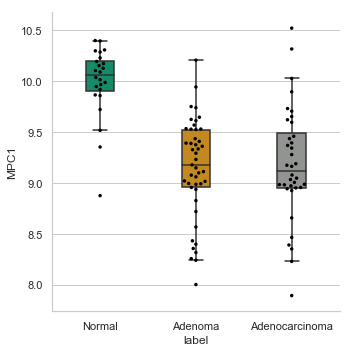

In [19]:
"""
LDH and MPC Relationship in Human Dataset GSE20916
"""
xp.gene_overview(df_GSE20916_labeled, info_GSE20916, gene_name='MPC1',palette=gse20916_colors, 
                  order=['Normal','Adenoma','Adenocarcinoma'],
                 save_fig=__path__ + 'plots/MPC1_boxswarm_GSE20916.pdf', grid=True, whitegrid=True)

<Figure size 432x288 with 0 Axes>

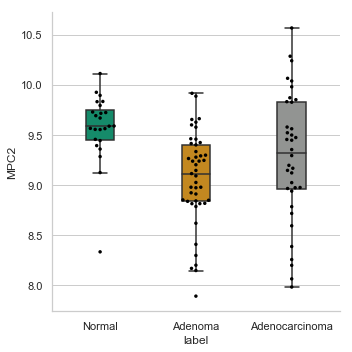

In [20]:
xp.gene_overview(df_GSE20916_labeled, info_GSE20916, gene_name='MPC2',palette=gse20916_colors, 
                  order=['Normal','Adenoma','Adenocarcinoma'],
                 save_fig=__path__ + 'plots/MPC2_boxswarm_GSE20916.pdf', grid=True, whitegrid=True)

<Figure size 432x288 with 0 Axes>

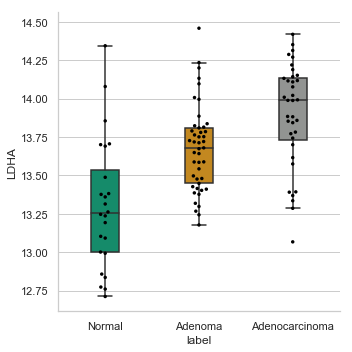

In [21]:
xp.gene_overview(df_GSE20916_labeled, info_GSE20916, gene_name='LDHA',palette=gse20916_colors, 
                  order=['Normal','Adenoma','Adenocarcinoma'],
                 save_fig=__path__ + 'plots/LDHA_boxswarm_GSE20916.pdf', grid=True, whitegrid=True)

<Figure size 432x288 with 0 Axes>

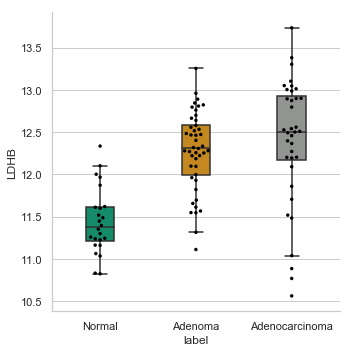

In [22]:
xp.gene_overview(df_GSE20916_labeled, info_GSE20916, gene_name='LDHB',palette=gse20916_colors, 
                  order=['Normal','Adenoma','Adenocarcinoma'],
                 save_fig=__path__ + 'plots/LDHB_boxswarm_GSE20916.pdf', grid=True, whitegrid=True)

In [23]:
#Statistical tests
GSE20916_stats = df_GSE20916_labeled.copy()
GSE20916_norm = GSE20916_stats[info_GSE20916.loc[info_GSE20916[1] == 'Normal'][0].tolist()]
GSE20916_ad = GSE20916_stats[info_GSE20916.loc[info_GSE20916[1] == 'Adenoma'][0].tolist()]
GSE20916_ac = GSE20916_stats[info_GSE20916.loc[info_GSE20916[1] == 'Adenocarcinoma'][0].tolist()]

p_vals_ad = []
p_vals_ac = []
genes = GSE20916_stats.index.tolist()

total = len(genes) - 1
counter = 1

for x in genes[1:]:
    s_ad, p_ad = stats.ranksums(xp.get_array(GSE20916_norm, str(x)), xp.get_array(GSE20916_ad, str(x)))
    p_vals_ad.append(p_ad) 
    
    s_ad, p_ac = stats.ranksums(xp.get_array(GSE20916_norm, str(x)), xp.get_array(GSE20916_ac, str(x)))
    p_vals_ac.append(p_ac)
    
    print(counter,'/',total)
    counter += 1

fdr_ad = multipletests(p_vals_ad, alpha=0.05, method='fdr_bh')
fdr_ac = multipletests(p_vals_ac, alpha=0.05, method='fdr_bh')

sig_data = pd.DataFrame()
sig_data[0] = p_vals_ad 
sig_data[1] = fdr_ad[1]
sig_data[2] = p_vals_ac
sig_data[3] = fdr_ac[1]

sig_data.index = genes[1:]

1 / 11967
2 / 11967
3 / 11967
4 / 11967
5 / 11967
6 / 11967
7 / 11967
8 / 11967
9 / 11967
10 / 11967
11 / 11967
12 / 11967
13 / 11967
14 / 11967
15 / 11967
16 / 11967
17 / 11967
18 / 11967
19 / 11967
20 / 11967
21 / 11967
22 / 11967
23 / 11967
24 / 11967
25 / 11967
26 / 11967
27 / 11967
28 / 11967
29 / 11967
30 / 11967
31 / 11967
32 / 11967
33 / 11967
34 / 11967
35 / 11967
36 / 11967
37 / 11967
38 / 11967
39 / 11967
40 / 11967
41 / 11967
42 / 11967
43 / 11967
44 / 11967
45 / 11967
46 / 11967
47 / 11967
48 / 11967
49 / 11967
50 / 11967
51 / 11967
52 / 11967
53 / 11967
54 / 11967
55 / 11967
56 / 11967
57 / 11967
58 / 11967
59 / 11967
60 / 11967
61 / 11967
62 / 11967
63 / 11967
64 / 11967
65 / 11967
66 / 11967
67 / 11967
68 / 11967
69 / 11967
70 / 11967
71 / 11967
72 / 11967
73 / 11967
74 / 11967
75 / 11967
76 / 11967
77 / 11967
78 / 11967
79 / 11967
80 / 11967
81 / 11967
82 / 11967
83 / 11967
84 / 11967
85 / 11967
86 / 11967
87 / 11967
88 / 11967
89 / 11967
90 / 11967
91 / 11967
92 / 119

694 / 11967
695 / 11967
696 / 11967
697 / 11967
698 / 11967
699 / 11967
700 / 11967
701 / 11967
702 / 11967
703 / 11967
704 / 11967
705 / 11967
706 / 11967
707 / 11967
708 / 11967
709 / 11967
710 / 11967
711 / 11967
712 / 11967
713 / 11967
714 / 11967
715 / 11967
716 / 11967
717 / 11967
718 / 11967
719 / 11967
720 / 11967
721 / 11967
722 / 11967
723 / 11967
724 / 11967
725 / 11967
726 / 11967
727 / 11967
728 / 11967
729 / 11967
730 / 11967
731 / 11967
732 / 11967
733 / 11967
734 / 11967
735 / 11967
736 / 11967
737 / 11967
738 / 11967
739 / 11967
740 / 11967
741 / 11967
742 / 11967
743 / 11967
744 / 11967
745 / 11967
746 / 11967
747 / 11967
748 / 11967
749 / 11967
750 / 11967
751 / 11967
752 / 11967
753 / 11967
754 / 11967
755 / 11967
756 / 11967
757 / 11967
758 / 11967
759 / 11967
760 / 11967
761 / 11967
762 / 11967
763 / 11967
764 / 11967
765 / 11967
766 / 11967
767 / 11967
768 / 11967
769 / 11967
770 / 11967
771 / 11967
772 / 11967
773 / 11967
774 / 11967
775 / 11967
776 / 11967
777 

1356 / 11967
1357 / 11967
1358 / 11967
1359 / 11967
1360 / 11967
1361 / 11967
1362 / 11967
1363 / 11967
1364 / 11967
1365 / 11967
1366 / 11967
1367 / 11967
1368 / 11967
1369 / 11967
1370 / 11967
1371 / 11967
1372 / 11967
1373 / 11967
1374 / 11967
1375 / 11967
1376 / 11967
1377 / 11967
1378 / 11967
1379 / 11967
1380 / 11967
1381 / 11967
1382 / 11967
1383 / 11967
1384 / 11967
1385 / 11967
1386 / 11967
1387 / 11967
1388 / 11967
1389 / 11967
1390 / 11967
1391 / 11967
1392 / 11967
1393 / 11967
1394 / 11967
1395 / 11967
1396 / 11967
1397 / 11967
1398 / 11967
1399 / 11967
1400 / 11967
1401 / 11967
1402 / 11967
1403 / 11967
1404 / 11967
1405 / 11967
1406 / 11967
1407 / 11967
1408 / 11967
1409 / 11967
1410 / 11967
1411 / 11967
1412 / 11967
1413 / 11967
1414 / 11967
1415 / 11967
1416 / 11967
1417 / 11967
1418 / 11967
1419 / 11967
1420 / 11967
1421 / 11967
1422 / 11967
1423 / 11967
1424 / 11967
1425 / 11967
1426 / 11967
1427 / 11967
1428 / 11967
1429 / 11967
1430 / 11967
1431 / 11967
1432 / 11967

1992 / 11967
1993 / 11967
1994 / 11967
1995 / 11967
1996 / 11967
1997 / 11967
1998 / 11967
1999 / 11967
2000 / 11967
2001 / 11967
2002 / 11967
2003 / 11967
2004 / 11967
2005 / 11967
2006 / 11967
2007 / 11967
2008 / 11967
2009 / 11967
2010 / 11967
2011 / 11967
2012 / 11967
2013 / 11967
2014 / 11967
2015 / 11967
2016 / 11967
2017 / 11967
2018 / 11967
2019 / 11967
2020 / 11967
2021 / 11967
2022 / 11967
2023 / 11967
2024 / 11967
2025 / 11967
2026 / 11967
2027 / 11967
2028 / 11967
2029 / 11967
2030 / 11967
2031 / 11967
2032 / 11967
2033 / 11967
2034 / 11967
2035 / 11967
2036 / 11967
2037 / 11967
2038 / 11967
2039 / 11967
2040 / 11967
2041 / 11967
2042 / 11967
2043 / 11967
2044 / 11967
2045 / 11967
2046 / 11967
2047 / 11967
2048 / 11967
2049 / 11967
2050 / 11967
2051 / 11967
2052 / 11967
2053 / 11967
2054 / 11967
2055 / 11967
2056 / 11967
2057 / 11967
2058 / 11967
2059 / 11967
2060 / 11967
2061 / 11967
2062 / 11967
2063 / 11967
2064 / 11967
2065 / 11967
2066 / 11967
2067 / 11967
2068 / 11967

2628 / 11967
2629 / 11967
2630 / 11967
2631 / 11967
2632 / 11967
2633 / 11967
2634 / 11967
2635 / 11967
2636 / 11967
2637 / 11967
2638 / 11967
2639 / 11967
2640 / 11967
2641 / 11967
2642 / 11967
2643 / 11967
2644 / 11967
2645 / 11967
2646 / 11967
2647 / 11967
2648 / 11967
2649 / 11967
2650 / 11967
2651 / 11967
2652 / 11967
2653 / 11967
2654 / 11967
2655 / 11967
2656 / 11967
2657 / 11967
2658 / 11967
2659 / 11967
2660 / 11967
2661 / 11967
2662 / 11967
2663 / 11967
2664 / 11967
2665 / 11967
2666 / 11967
2667 / 11967
2668 / 11967
2669 / 11967
2670 / 11967
2671 / 11967
2672 / 11967
2673 / 11967
2674 / 11967
2675 / 11967
2676 / 11967
2677 / 11967
2678 / 11967
2679 / 11967
2680 / 11967
2681 / 11967
2682 / 11967
2683 / 11967
2684 / 11967
2685 / 11967
2686 / 11967
2687 / 11967
2688 / 11967
2689 / 11967
2690 / 11967
2691 / 11967
2692 / 11967
2693 / 11967
2694 / 11967
2695 / 11967
2696 / 11967
2697 / 11967
2698 / 11967
2699 / 11967
2700 / 11967
2701 / 11967
2702 / 11967
2703 / 11967
2704 / 11967

3272 / 11967
3273 / 11967
3274 / 11967
3275 / 11967
3276 / 11967
3277 / 11967
3278 / 11967
3279 / 11967
3280 / 11967
3281 / 11967
3282 / 11967
3283 / 11967
3284 / 11967
3285 / 11967
3286 / 11967
3287 / 11967
3288 / 11967
3289 / 11967
3290 / 11967
3291 / 11967
3292 / 11967
3293 / 11967
3294 / 11967
3295 / 11967
3296 / 11967
3297 / 11967
3298 / 11967
3299 / 11967
3300 / 11967
3301 / 11967
3302 / 11967
3303 / 11967
3304 / 11967
3305 / 11967
3306 / 11967
3307 / 11967
3308 / 11967
3309 / 11967
3310 / 11967
3311 / 11967
3312 / 11967
3313 / 11967
3314 / 11967
3315 / 11967
3316 / 11967
3317 / 11967
3318 / 11967
3319 / 11967
3320 / 11967
3321 / 11967
3322 / 11967
3323 / 11967
3324 / 11967
3325 / 11967
3326 / 11967
3327 / 11967
3328 / 11967
3329 / 11967
3330 / 11967
3331 / 11967
3332 / 11967
3333 / 11967
3334 / 11967
3335 / 11967
3336 / 11967
3337 / 11967
3338 / 11967
3339 / 11967
3340 / 11967
3341 / 11967
3342 / 11967
3343 / 11967
3344 / 11967
3345 / 11967
3346 / 11967
3347 / 11967
3348 / 11967

3911 / 11967
3912 / 11967
3913 / 11967
3914 / 11967
3915 / 11967
3916 / 11967
3917 / 11967
3918 / 11967
3919 / 11967
3920 / 11967
3921 / 11967
3922 / 11967
3923 / 11967
3924 / 11967
3925 / 11967
3926 / 11967
3927 / 11967
3928 / 11967
3929 / 11967
3930 / 11967
3931 / 11967
3932 / 11967
3933 / 11967
3934 / 11967
3935 / 11967
3936 / 11967
3937 / 11967
3938 / 11967
3939 / 11967
3940 / 11967
3941 / 11967
3942 / 11967
3943 / 11967
3944 / 11967
3945 / 11967
3946 / 11967
3947 / 11967
3948 / 11967
3949 / 11967
3950 / 11967
3951 / 11967
3952 / 11967
3953 / 11967
3954 / 11967
3955 / 11967
3956 / 11967
3957 / 11967
3958 / 11967
3959 / 11967
3960 / 11967
3961 / 11967
3962 / 11967
3963 / 11967
3964 / 11967
3965 / 11967
3966 / 11967
3967 / 11967
3968 / 11967
3969 / 11967
3970 / 11967
3971 / 11967
3972 / 11967
3973 / 11967
3974 / 11967
3975 / 11967
3976 / 11967
3977 / 11967
3978 / 11967
3979 / 11967
3980 / 11967
3981 / 11967
3982 / 11967
3983 / 11967
3984 / 11967
3985 / 11967
3986 / 11967
3987 / 11967

4554 / 11967
4555 / 11967
4556 / 11967
4557 / 11967
4558 / 11967
4559 / 11967
4560 / 11967
4561 / 11967
4562 / 11967
4563 / 11967
4564 / 11967
4565 / 11967
4566 / 11967
4567 / 11967
4568 / 11967
4569 / 11967
4570 / 11967
4571 / 11967
4572 / 11967
4573 / 11967
4574 / 11967
4575 / 11967
4576 / 11967
4577 / 11967
4578 / 11967
4579 / 11967
4580 / 11967
4581 / 11967
4582 / 11967
4583 / 11967
4584 / 11967
4585 / 11967
4586 / 11967
4587 / 11967
4588 / 11967
4589 / 11967
4590 / 11967
4591 / 11967
4592 / 11967
4593 / 11967
4594 / 11967
4595 / 11967
4596 / 11967
4597 / 11967
4598 / 11967
4599 / 11967
4600 / 11967
4601 / 11967
4602 / 11967
4603 / 11967
4604 / 11967
4605 / 11967
4606 / 11967
4607 / 11967
4608 / 11967
4609 / 11967
4610 / 11967
4611 / 11967
4612 / 11967
4613 / 11967
4614 / 11967
4615 / 11967
4616 / 11967
4617 / 11967
4618 / 11967
4619 / 11967
4620 / 11967
4621 / 11967
4622 / 11967
4623 / 11967
4624 / 11967
4625 / 11967
4626 / 11967
4627 / 11967
4628 / 11967
4629 / 11967
4630 / 11967

5185 / 11967
5186 / 11967
5187 / 11967
5188 / 11967
5189 / 11967
5190 / 11967
5191 / 11967
5192 / 11967
5193 / 11967
5194 / 11967
5195 / 11967
5196 / 11967
5197 / 11967
5198 / 11967
5199 / 11967
5200 / 11967
5201 / 11967
5202 / 11967
5203 / 11967
5204 / 11967
5205 / 11967
5206 / 11967
5207 / 11967
5208 / 11967
5209 / 11967
5210 / 11967
5211 / 11967
5212 / 11967
5213 / 11967
5214 / 11967
5215 / 11967
5216 / 11967
5217 / 11967
5218 / 11967
5219 / 11967
5220 / 11967
5221 / 11967
5222 / 11967
5223 / 11967
5224 / 11967
5225 / 11967
5226 / 11967
5227 / 11967
5228 / 11967
5229 / 11967
5230 / 11967
5231 / 11967
5232 / 11967
5233 / 11967
5234 / 11967
5235 / 11967
5236 / 11967
5237 / 11967
5238 / 11967
5239 / 11967
5240 / 11967
5241 / 11967
5242 / 11967
5243 / 11967
5244 / 11967
5245 / 11967
5246 / 11967
5247 / 11967
5248 / 11967
5249 / 11967
5250 / 11967
5251 / 11967
5252 / 11967
5253 / 11967
5254 / 11967
5255 / 11967
5256 / 11967
5257 / 11967
5258 / 11967
5259 / 11967
5260 / 11967
5261 / 11967

5829 / 11967
5830 / 11967
5831 / 11967
5832 / 11967
5833 / 11967
5834 / 11967
5835 / 11967
5836 / 11967
5837 / 11967
5838 / 11967
5839 / 11967
5840 / 11967
5841 / 11967
5842 / 11967
5843 / 11967
5844 / 11967
5845 / 11967
5846 / 11967
5847 / 11967
5848 / 11967
5849 / 11967
5850 / 11967
5851 / 11967
5852 / 11967
5853 / 11967
5854 / 11967
5855 / 11967
5856 / 11967
5857 / 11967
5858 / 11967
5859 / 11967
5860 / 11967
5861 / 11967
5862 / 11967
5863 / 11967
5864 / 11967
5865 / 11967
5866 / 11967
5867 / 11967
5868 / 11967
5869 / 11967
5870 / 11967
5871 / 11967
5872 / 11967
5873 / 11967
5874 / 11967
5875 / 11967
5876 / 11967
5877 / 11967
5878 / 11967
5879 / 11967
5880 / 11967
5881 / 11967
5882 / 11967
5883 / 11967
5884 / 11967
5885 / 11967
5886 / 11967
5887 / 11967
5888 / 11967
5889 / 11967
5890 / 11967
5891 / 11967
5892 / 11967
5893 / 11967
5894 / 11967
5895 / 11967
5896 / 11967
5897 / 11967
5898 / 11967
5899 / 11967
5900 / 11967
5901 / 11967
5902 / 11967
5903 / 11967
5904 / 11967
5905 / 11967

6464 / 11967
6465 / 11967
6466 / 11967
6467 / 11967
6468 / 11967
6469 / 11967
6470 / 11967
6471 / 11967
6472 / 11967
6473 / 11967
6474 / 11967
6475 / 11967
6476 / 11967
6477 / 11967
6478 / 11967
6479 / 11967
6480 / 11967
6481 / 11967
6482 / 11967
6483 / 11967
6484 / 11967
6485 / 11967
6486 / 11967
6487 / 11967
6488 / 11967
6489 / 11967
6490 / 11967
6491 / 11967
6492 / 11967
6493 / 11967
6494 / 11967
6495 / 11967
6496 / 11967
6497 / 11967
6498 / 11967
6499 / 11967
6500 / 11967
6501 / 11967
6502 / 11967
6503 / 11967
6504 / 11967
6505 / 11967
6506 / 11967
6507 / 11967
6508 / 11967
6509 / 11967
6510 / 11967
6511 / 11967
6512 / 11967
6513 / 11967
6514 / 11967
6515 / 11967
6516 / 11967
6517 / 11967
6518 / 11967
6519 / 11967
6520 / 11967
6521 / 11967
6522 / 11967
6523 / 11967
6524 / 11967
6525 / 11967
6526 / 11967
6527 / 11967
6528 / 11967
6529 / 11967
6530 / 11967
6531 / 11967
6532 / 11967
6533 / 11967
6534 / 11967
6535 / 11967
6536 / 11967
6537 / 11967
6538 / 11967
6539 / 11967
6540 / 11967

7095 / 11967
7096 / 11967
7097 / 11967
7098 / 11967
7099 / 11967
7100 / 11967
7101 / 11967
7102 / 11967
7103 / 11967
7104 / 11967
7105 / 11967
7106 / 11967
7107 / 11967
7108 / 11967
7109 / 11967
7110 / 11967
7111 / 11967
7112 / 11967
7113 / 11967
7114 / 11967
7115 / 11967
7116 / 11967
7117 / 11967
7118 / 11967
7119 / 11967
7120 / 11967
7121 / 11967
7122 / 11967
7123 / 11967
7124 / 11967
7125 / 11967
7126 / 11967
7127 / 11967
7128 / 11967
7129 / 11967
7130 / 11967
7131 / 11967
7132 / 11967
7133 / 11967
7134 / 11967
7135 / 11967
7136 / 11967
7137 / 11967
7138 / 11967
7139 / 11967
7140 / 11967
7141 / 11967
7142 / 11967
7143 / 11967
7144 / 11967
7145 / 11967
7146 / 11967
7147 / 11967
7148 / 11967
7149 / 11967
7150 / 11967
7151 / 11967
7152 / 11967
7153 / 11967
7154 / 11967
7155 / 11967
7156 / 11967
7157 / 11967
7158 / 11967
7159 / 11967
7160 / 11967
7161 / 11967
7162 / 11967
7163 / 11967
7164 / 11967
7165 / 11967
7166 / 11967
7167 / 11967
7168 / 11967
7169 / 11967
7170 / 11967
7171 / 11967

7732 / 11967
7733 / 11967
7734 / 11967
7735 / 11967
7736 / 11967
7737 / 11967
7738 / 11967
7739 / 11967
7740 / 11967
7741 / 11967
7742 / 11967
7743 / 11967
7744 / 11967
7745 / 11967
7746 / 11967
7747 / 11967
7748 / 11967
7749 / 11967
7750 / 11967
7751 / 11967
7752 / 11967
7753 / 11967
7754 / 11967
7755 / 11967
7756 / 11967
7757 / 11967
7758 / 11967
7759 / 11967
7760 / 11967
7761 / 11967
7762 / 11967
7763 / 11967
7764 / 11967
7765 / 11967
7766 / 11967
7767 / 11967
7768 / 11967
7769 / 11967
7770 / 11967
7771 / 11967
7772 / 11967
7773 / 11967
7774 / 11967
7775 / 11967
7776 / 11967
7777 / 11967
7778 / 11967
7779 / 11967
7780 / 11967
7781 / 11967
7782 / 11967
7783 / 11967
7784 / 11967
7785 / 11967
7786 / 11967
7787 / 11967
7788 / 11967
7789 / 11967
7790 / 11967
7791 / 11967
7792 / 11967
7793 / 11967
7794 / 11967
7795 / 11967
7796 / 11967
7797 / 11967
7798 / 11967
7799 / 11967
7800 / 11967
7801 / 11967
7802 / 11967
7803 / 11967
7804 / 11967
7805 / 11967
7806 / 11967
7807 / 11967
7808 / 11967

8368 / 11967
8369 / 11967
8370 / 11967
8371 / 11967
8372 / 11967
8373 / 11967
8374 / 11967
8375 / 11967
8376 / 11967
8377 / 11967
8378 / 11967
8379 / 11967
8380 / 11967
8381 / 11967
8382 / 11967
8383 / 11967
8384 / 11967
8385 / 11967
8386 / 11967
8387 / 11967
8388 / 11967
8389 / 11967
8390 / 11967
8391 / 11967
8392 / 11967
8393 / 11967
8394 / 11967
8395 / 11967
8396 / 11967
8397 / 11967
8398 / 11967
8399 / 11967
8400 / 11967
8401 / 11967
8402 / 11967
8403 / 11967
8404 / 11967
8405 / 11967
8406 / 11967
8407 / 11967
8408 / 11967
8409 / 11967
8410 / 11967
8411 / 11967
8412 / 11967
8413 / 11967
8414 / 11967
8415 / 11967
8416 / 11967
8417 / 11967
8418 / 11967
8419 / 11967
8420 / 11967
8421 / 11967
8422 / 11967
8423 / 11967
8424 / 11967
8425 / 11967
8426 / 11967
8427 / 11967
8428 / 11967
8429 / 11967
8430 / 11967
8431 / 11967
8432 / 11967
8433 / 11967
8434 / 11967
8435 / 11967
8436 / 11967
8437 / 11967
8438 / 11967
8439 / 11967
8440 / 11967
8441 / 11967
8442 / 11967
8443 / 11967
8444 / 11967

9001 / 11967
9002 / 11967
9003 / 11967
9004 / 11967
9005 / 11967
9006 / 11967
9007 / 11967
9008 / 11967
9009 / 11967
9010 / 11967
9011 / 11967
9012 / 11967
9013 / 11967
9014 / 11967
9015 / 11967
9016 / 11967
9017 / 11967
9018 / 11967
9019 / 11967
9020 / 11967
9021 / 11967
9022 / 11967
9023 / 11967
9024 / 11967
9025 / 11967
9026 / 11967
9027 / 11967
9028 / 11967
9029 / 11967
9030 / 11967
9031 / 11967
9032 / 11967
9033 / 11967
9034 / 11967
9035 / 11967
9036 / 11967
9037 / 11967
9038 / 11967
9039 / 11967
9040 / 11967
9041 / 11967
9042 / 11967
9043 / 11967
9044 / 11967
9045 / 11967
9046 / 11967
9047 / 11967
9048 / 11967
9049 / 11967
9050 / 11967
9051 / 11967
9052 / 11967
9053 / 11967
9054 / 11967
9055 / 11967
9056 / 11967
9057 / 11967
9058 / 11967
9059 / 11967
9060 / 11967
9061 / 11967
9062 / 11967
9063 / 11967
9064 / 11967
9065 / 11967
9066 / 11967
9067 / 11967
9068 / 11967
9069 / 11967
9070 / 11967
9071 / 11967
9072 / 11967
9073 / 11967
9074 / 11967
9075 / 11967
9076 / 11967
9077 / 11967

9639 / 11967
9640 / 11967
9641 / 11967
9642 / 11967
9643 / 11967
9644 / 11967
9645 / 11967
9646 / 11967
9647 / 11967
9648 / 11967
9649 / 11967
9650 / 11967
9651 / 11967
9652 / 11967
9653 / 11967
9654 / 11967
9655 / 11967
9656 / 11967
9657 / 11967
9658 / 11967
9659 / 11967
9660 / 11967
9661 / 11967
9662 / 11967
9663 / 11967
9664 / 11967
9665 / 11967
9666 / 11967
9667 / 11967
9668 / 11967
9669 / 11967
9670 / 11967
9671 / 11967
9672 / 11967
9673 / 11967
9674 / 11967
9675 / 11967
9676 / 11967
9677 / 11967
9678 / 11967
9679 / 11967
9680 / 11967
9681 / 11967
9682 / 11967
9683 / 11967
9684 / 11967
9685 / 11967
9686 / 11967
9687 / 11967
9688 / 11967
9689 / 11967
9690 / 11967
9691 / 11967
9692 / 11967
9693 / 11967
9694 / 11967
9695 / 11967
9696 / 11967
9697 / 11967
9698 / 11967
9699 / 11967
9700 / 11967
9701 / 11967
9702 / 11967
9703 / 11967
9704 / 11967
9705 / 11967
9706 / 11967
9707 / 11967
9708 / 11967
9709 / 11967
9710 / 11967
9711 / 11967
9712 / 11967
9713 / 11967
9714 / 11967
9715 / 11967

10250 / 11967
10251 / 11967
10252 / 11967
10253 / 11967
10254 / 11967
10255 / 11967
10256 / 11967
10257 / 11967
10258 / 11967
10259 / 11967
10260 / 11967
10261 / 11967
10262 / 11967
10263 / 11967
10264 / 11967
10265 / 11967
10266 / 11967
10267 / 11967
10268 / 11967
10269 / 11967
10270 / 11967
10271 / 11967
10272 / 11967
10273 / 11967
10274 / 11967
10275 / 11967
10276 / 11967
10277 / 11967
10278 / 11967
10279 / 11967
10280 / 11967
10281 / 11967
10282 / 11967
10283 / 11967
10284 / 11967
10285 / 11967
10286 / 11967
10287 / 11967
10288 / 11967
10289 / 11967
10290 / 11967
10291 / 11967
10292 / 11967
10293 / 11967
10294 / 11967
10295 / 11967
10296 / 11967
10297 / 11967
10298 / 11967
10299 / 11967
10300 / 11967
10301 / 11967
10302 / 11967
10303 / 11967
10304 / 11967
10305 / 11967
10306 / 11967
10307 / 11967
10308 / 11967
10309 / 11967
10310 / 11967
10311 / 11967
10312 / 11967
10313 / 11967
10314 / 11967
10315 / 11967
10316 / 11967
10317 / 11967
10318 / 11967
10319 / 11967
10320 / 11967
10321 

10846 / 11967
10847 / 11967
10848 / 11967
10849 / 11967
10850 / 11967
10851 / 11967
10852 / 11967
10853 / 11967
10854 / 11967
10855 / 11967
10856 / 11967
10857 / 11967
10858 / 11967
10859 / 11967
10860 / 11967
10861 / 11967
10862 / 11967
10863 / 11967
10864 / 11967
10865 / 11967
10866 / 11967
10867 / 11967
10868 / 11967
10869 / 11967
10870 / 11967
10871 / 11967
10872 / 11967
10873 / 11967
10874 / 11967
10875 / 11967
10876 / 11967
10877 / 11967
10878 / 11967
10879 / 11967
10880 / 11967
10881 / 11967
10882 / 11967
10883 / 11967
10884 / 11967
10885 / 11967
10886 / 11967
10887 / 11967
10888 / 11967
10889 / 11967
10890 / 11967
10891 / 11967
10892 / 11967
10893 / 11967
10894 / 11967
10895 / 11967
10896 / 11967
10897 / 11967
10898 / 11967
10899 / 11967
10900 / 11967
10901 / 11967
10902 / 11967
10903 / 11967
10904 / 11967
10905 / 11967
10906 / 11967
10907 / 11967
10908 / 11967
10909 / 11967
10910 / 11967
10911 / 11967
10912 / 11967
10913 / 11967
10914 / 11967
10915 / 11967
10916 / 11967
10917 

11440 / 11967
11441 / 11967
11442 / 11967
11443 / 11967
11444 / 11967
11445 / 11967
11446 / 11967
11447 / 11967
11448 / 11967
11449 / 11967
11450 / 11967
11451 / 11967
11452 / 11967
11453 / 11967
11454 / 11967
11455 / 11967
11456 / 11967
11457 / 11967
11458 / 11967
11459 / 11967
11460 / 11967
11461 / 11967
11462 / 11967
11463 / 11967
11464 / 11967
11465 / 11967
11466 / 11967
11467 / 11967
11468 / 11967
11469 / 11967
11470 / 11967
11471 / 11967
11472 / 11967
11473 / 11967
11474 / 11967
11475 / 11967
11476 / 11967
11477 / 11967
11478 / 11967
11479 / 11967
11480 / 11967
11481 / 11967
11482 / 11967
11483 / 11967
11484 / 11967
11485 / 11967
11486 / 11967
11487 / 11967
11488 / 11967
11489 / 11967
11490 / 11967
11491 / 11967
11492 / 11967
11493 / 11967
11494 / 11967
11495 / 11967
11496 / 11967
11497 / 11967
11498 / 11967
11499 / 11967
11500 / 11967
11501 / 11967
11502 / 11967
11503 / 11967
11504 / 11967
11505 / 11967
11506 / 11967
11507 / 11967
11508 / 11967
11509 / 11967
11510 / 11967
11511 

In [24]:
print('GSE20916 FDR for Normal vs Adenoma')

#MPC1
print('MPC1: FDR=' + str(sig_data.loc['MPC1'][1]))

#MPC2
print('MPC2: FDR=' + str(sig_data.loc['MPC2'][1]))

#LDHA
print('LDHA: FDR=' + str(sig_data.loc['LDHA'][1]))

#LDHB
print('LDHB: FDR=' + str(sig_data.loc['LDHB'][1]))

print('')
print('GSE20916 FDR for Normal vs Adenocarcinoma')

#MPC1
print('MPC1: FDR=' + str(sig_data.loc['MPC1'][3]))

#MPC2
print('MPC2: FDR=' + str(sig_data.loc['MPC2'][3]))

#LDHA
print('LDHA: FDR=' + str(sig_data.loc['LDHA'][3]))

#LDHB
print('LDHB: FDR=' + str(sig_data.loc['LDHB'][3]))

GSE20916 FDR for Normal vs Adenoma
MPC1: FDR=9.791300308807664e-08
MPC2: FDR=1.7172807817415693e-05
LDHA: FDR=0.0002574743207763419
LDHB: FDR=2.8134953763073485e-07

GSE20916 FDR for Normal vs Adenocarcinoma
MPC1: FDR=4.746379251491133e-06
MPC2: FDR=0.06426095127053551
LDHA: FDR=1.474973692220452e-05
LDHB: FDR=1.896386031707828e-05


## Pyruvate Metabolism in Human Microarrays and Mouse Nanostring Experiments

<Figure size 432x288 with 0 Axes>

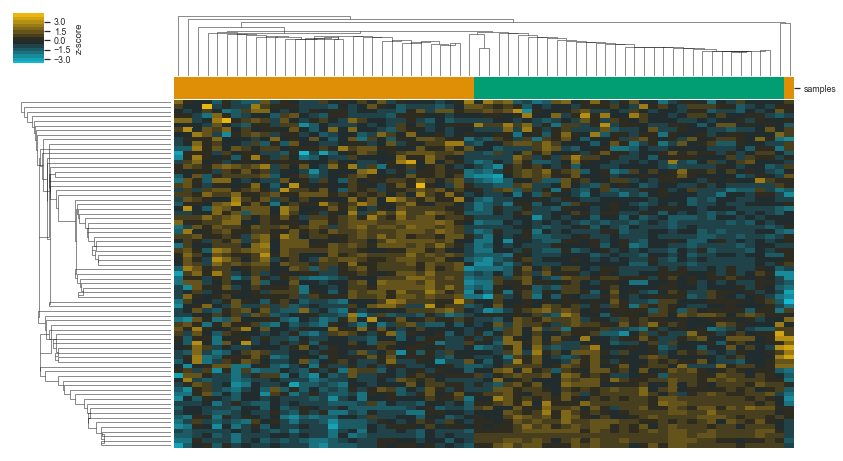

In [25]:
"""
Pyruvate-related Gene Expression Changes in Human Dataset GSE8671
"""
xp.heatmap(df_GSE8671_scaled_sorted, info_GSE8671, sample_palette=gse8671_colors, gene_list=pyru_list, 
            figsize=(14,8), save_fig=(__path__ + 'plots/GSE8671_customPyruvate_heatmap_colclustered.pdf'),
            row_cluster=True, col_cluster=True, yticklabels=False, xticklabels=False,
            cbar_kws={'label': 'z-score'}, linewidths=0)

<Figure size 432x288 with 0 Axes>

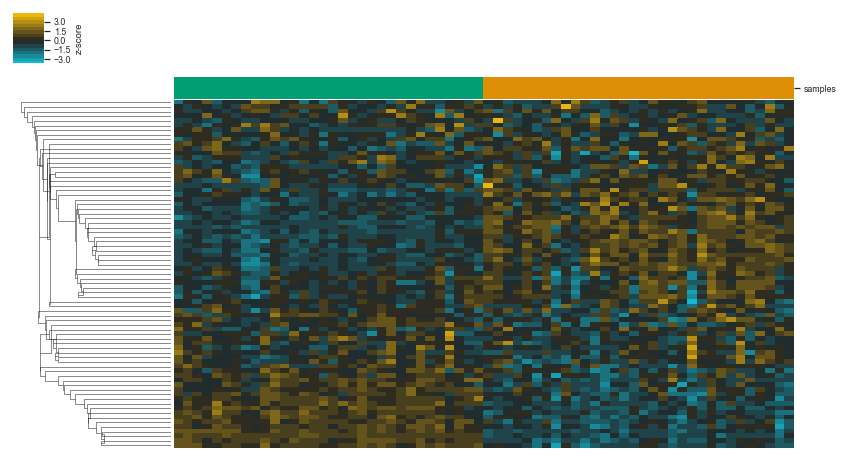

In [26]:
xp.heatmap(df_GSE8671_scaled_sorted, info_GSE8671, sample_palette=gse8671_colors, gene_list=pyru_list, 
            figsize=(14,8), save_fig=(__path__ + 'plots/GSE8671_customPyruvate_heatmap.pdf'),
            row_cluster=True, col_cluster=False, yticklabels=False, xticklabels=False,
            cbar_kws={'label': 'z-score'}, linewidths=0)

<Figure size 432x288 with 0 Axes>

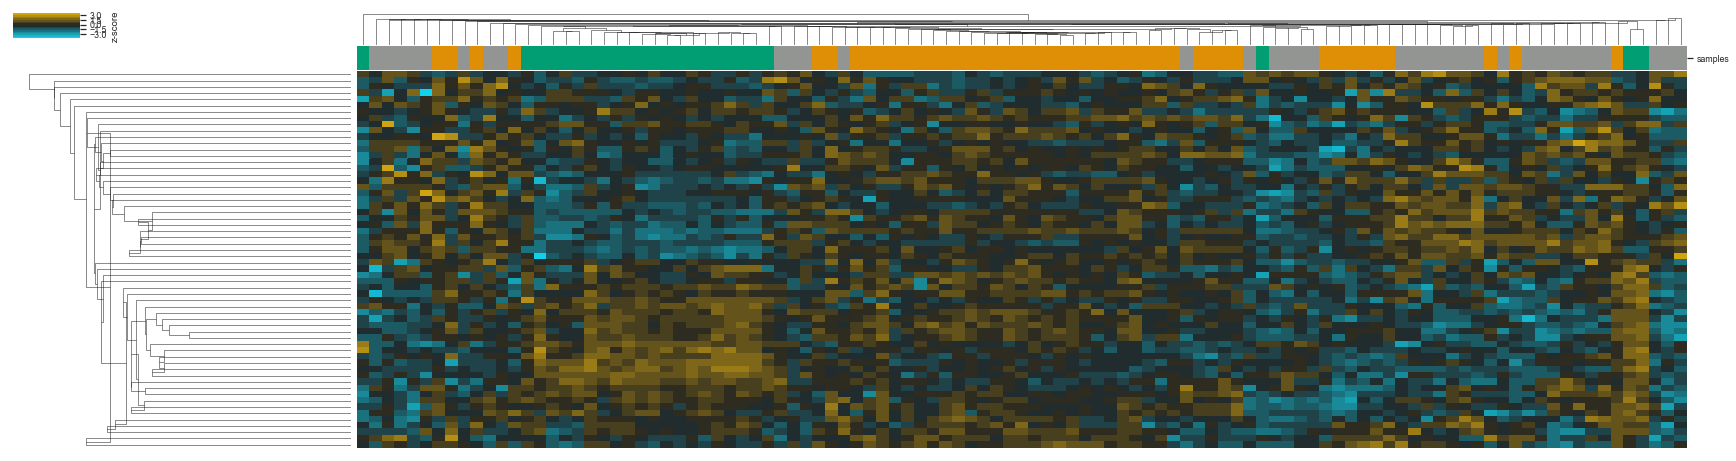

In [27]:
"""
Pyruvate-related Gene Expression Changes in Human Dataset GSE20916
"""
xp.heatmap(df_GSE20916_scaled_sorted, info_GSE20916, sample_palette=gse20916_colors, gene_list=pyru_list, 
            figsize=(30,8), save_fig=(__path__ + 'plots/GSE20916_customPyruvate_heatmap_colclustered.pdf'),
            row_cluster=True, col_cluster=True, yticklabels=False, xticklabels=False,
            cbar_kws={'label': 'z-score'}, linewidths=0)

<Figure size 432x288 with 0 Axes>

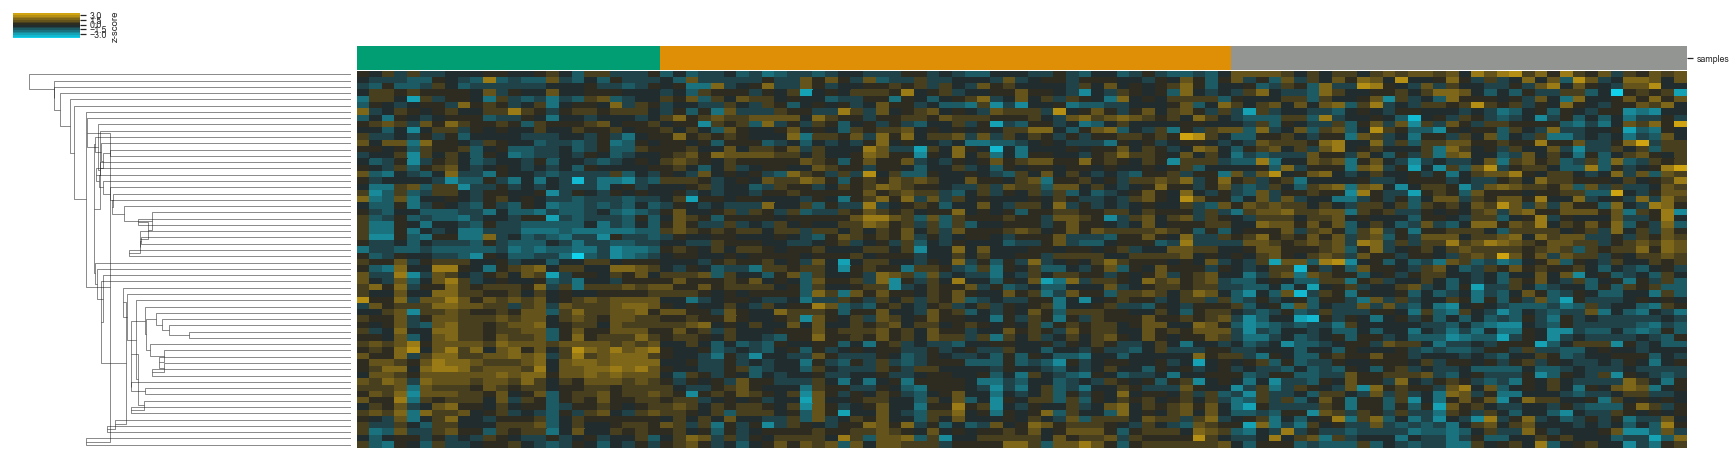

In [28]:
xp.heatmap(df_GSE20916_scaled_sorted, info_GSE20916, sample_palette=gse20916_colors, gene_list=pyru_list, 
            figsize=(30,8), save_fig=(__path__ + 'plots/GSE20916_customPyruvate_heatmap.pdf'),
            row_cluster=True, col_cluster=False, yticklabels=False, xticklabels=False,
            cbar_kws={'label': 'z-score'}, linewidths=0)

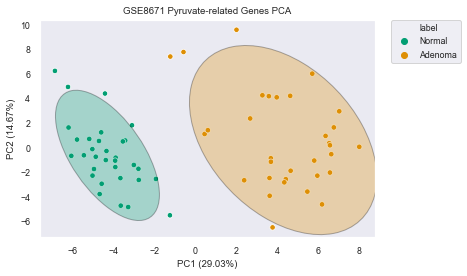

In [29]:
"""
Pyruvate-related Gene Expression Changes in Human Dataset GSE8671 -- PCA
"""
xp.pca(df_GSE8671_scaled, info_GSE8671, palette=gse8671_colors,
        gene_list=pyru_list,
       save_scree=__path__ + 'plots/GSE8671_pyru_list_PCA_scree.pdf',
       title='GSE8671 Pyruvate-related Genes PCA', 
        save_fig=__path__ + 'plots/GSE8671_pyru_list_2CI_PCA.pdf')

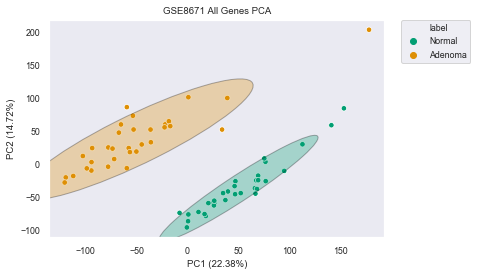

In [30]:
"""
Overall Gene Expression Changes in Human Dataset GSE8671 -- PCA
"""
xp.pca(df_GSE8671_scaled, info_GSE8671, palette=gse8671_colors,
       save_scree=__path__ + 'plots/GSE8671_all_genes_PCA_scree.pdf',
       title='GSE8671 All Genes PCA', 
        save_fig=__path__ + 'plots/GSE8671_all_genes_2CI_PCA.pdf')

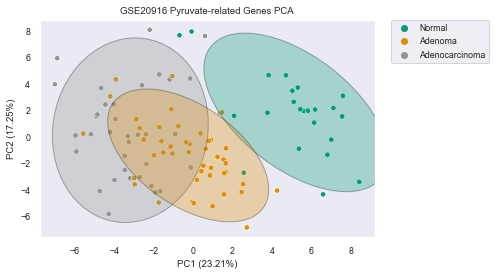

In [31]:
"""
Pyruvate-related Gene Expression Changes in Human Dataset GSE20916 -- PCA
"""
xp.pca(df_GSE20916_scaled, info_GSE20916, palette=gse20916_colors, order_legend=[1,3,2],
        gene_list=pyru_list,
       save_scree=__path__ + 'plots/GSE20916_pyru_list_PCA_scree.pdf',
       title='GSE20916 Pyruvate-related Genes PCA', 
        save_fig=__path__ + 'plots/GSE20916_pyru_list_2CI_PCA.pdf')

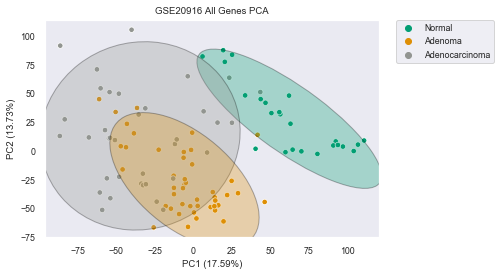

In [32]:
"""
Overall Gene Expression Changes in Human Dataset GSE20916 -- PCA
"""
xp.pca(df_GSE20916_scaled, info_GSE20916, palette=gse20916_colors, order_legend=[1,3,2],
       save_scree=__path__ + 'plots/GSE20916_all_genes_PCA_scree.pdf',
       title='GSE20916 All Genes PCA', 
        save_fig=__path__ + 'plots/GSE20916_all_genes_2CI_PCA.pdf')

## Mouse Nanostring and Human Microarray Heatmaps -- Custom22 Probe Genes 

<Figure size 432x288 with 0 Axes>

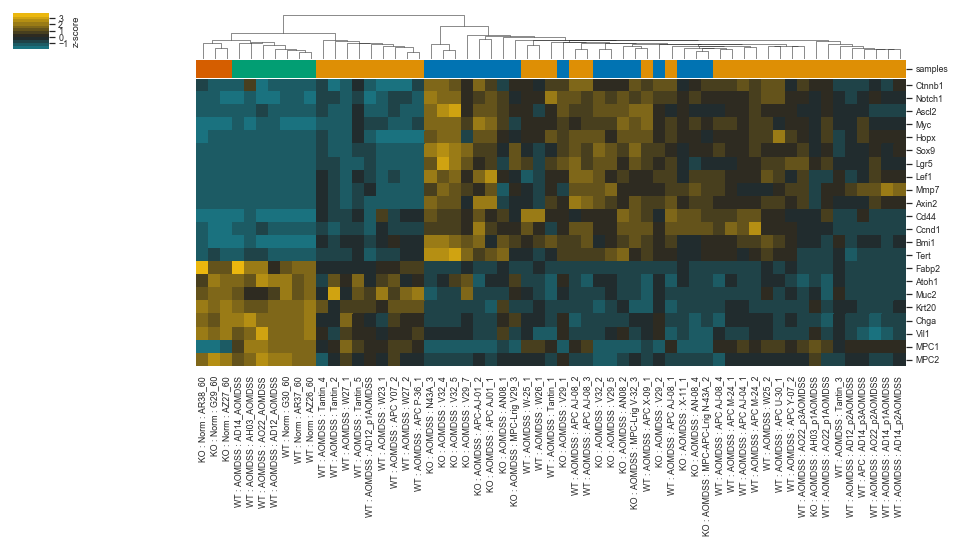

In [33]:
"""
Mouse AOMDSS Heatmap Custom22 Probes
"""
xp.heatmap(aomdss_scaled, aomdss_info, sample_palette=aomdss_colors, gene_list=custom22_mouse, 
            figsize=(16,6.5), save_fig=(__path__ + 'plots/AOMDSS_custom22_heatmap.pdf'), 
            cbar_kws={'label': 'z-score'}, linewidths=0)

<Figure size 432x288 with 0 Axes>

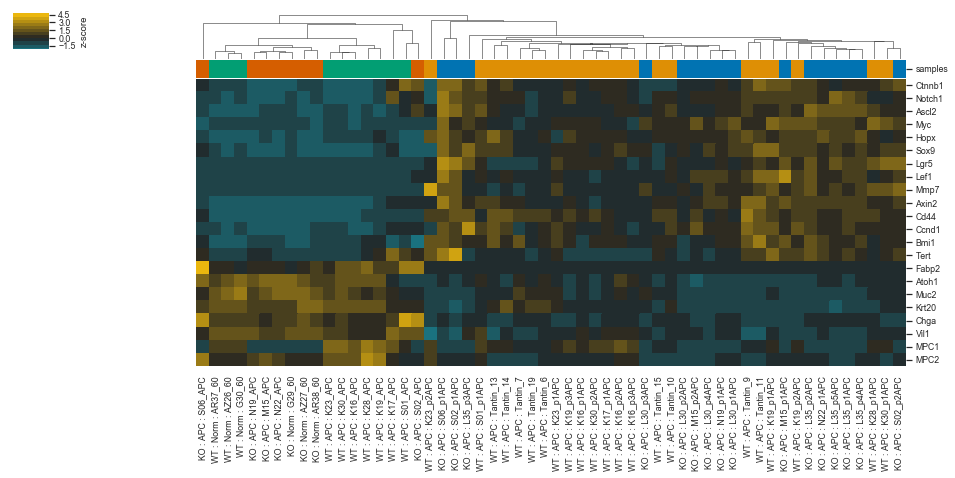

In [34]:
"""
Mouse APC Heatmap Custom22 Probes
"""
xp.heatmap(apc_scaled, apc_info, sample_palette=apc_colors, gene_list=custom22_mouse, 
            figsize=(16,6.5), save_fig=(__path__ + 'plots/APC_custom22_heatmap.pdf'), 
            cbar_kws={'label': 'z-score'}, linewidths=0)

<Figure size 432x288 with 0 Axes>

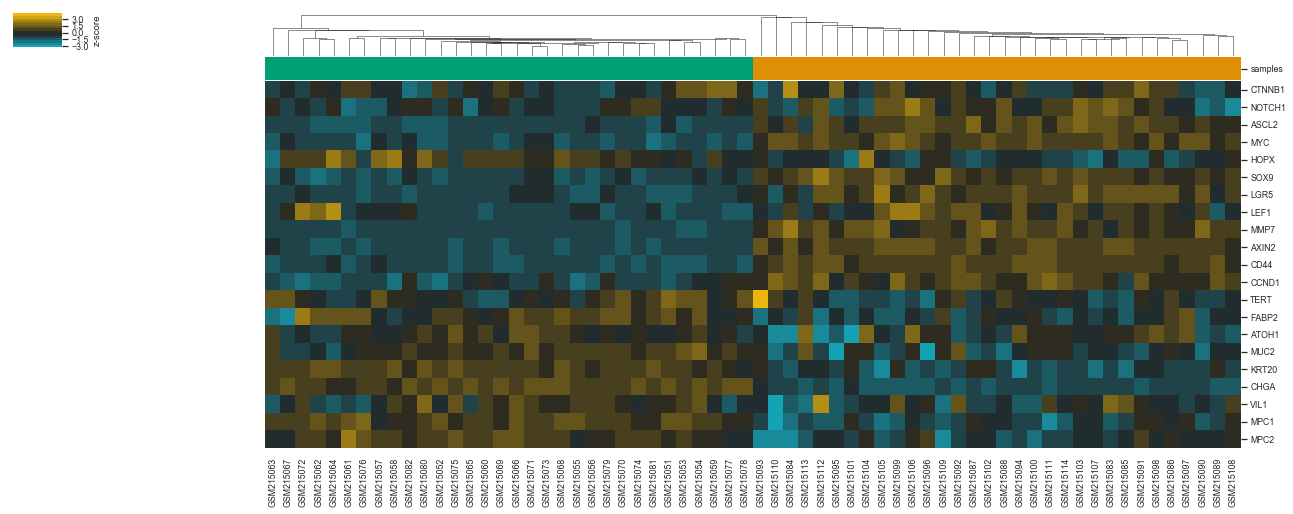

In [35]:
"""
Human GSE8671 Heatmap Custom22 Probes
"""
xp.heatmap(df_GSE8671_scaled, info_GSE8671, sample_palette=gse8671_colors, gene_list=custom22_human, 
            figsize=(22,8), save_fig=(__path__ + 'plots/GSE8671_custom22_heatmap.pdf'), 
            cbar_kws={'label': 'z-score'}, linewidths=0)

<Figure size 432x288 with 0 Axes>

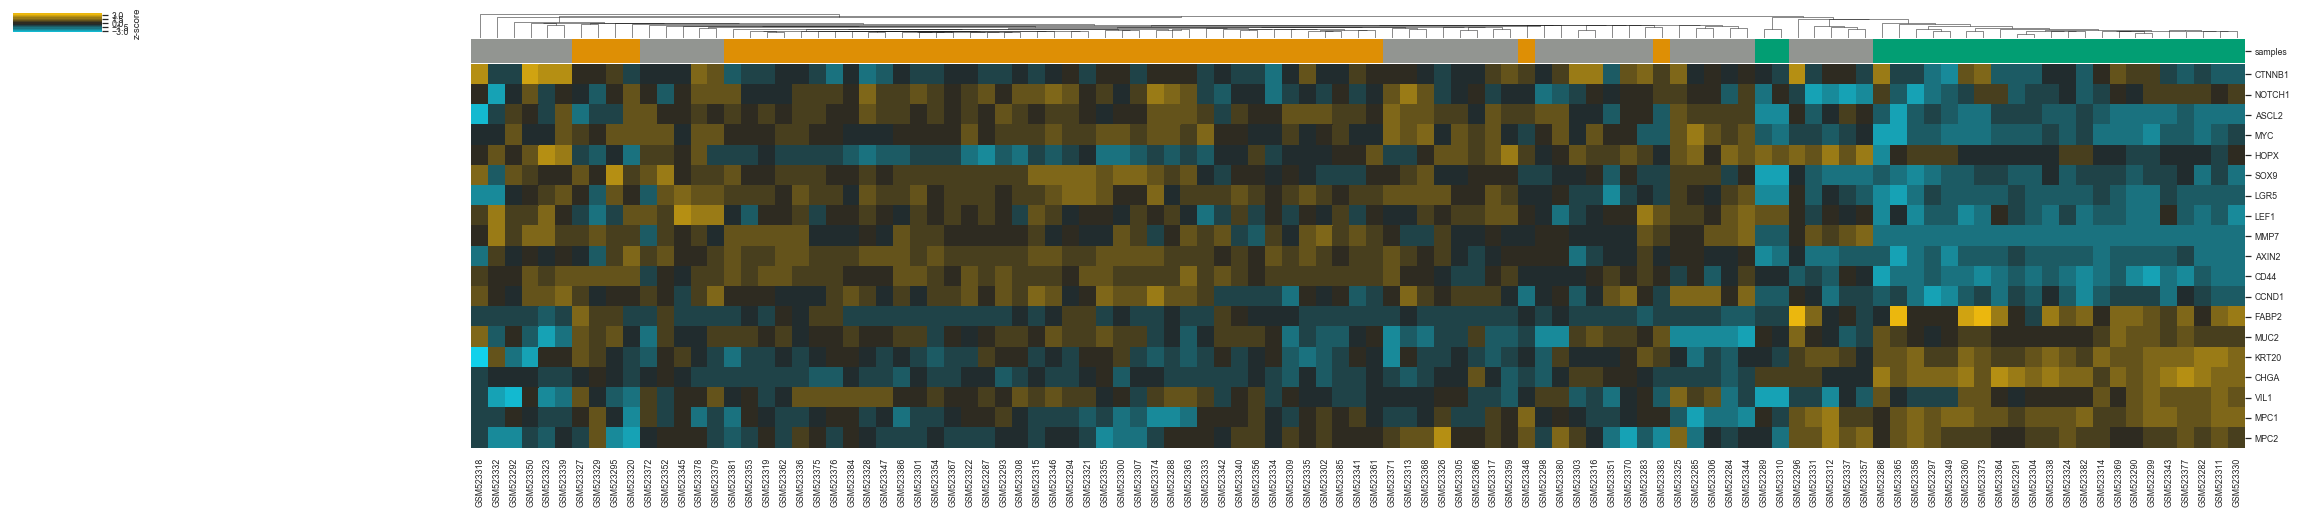

In [36]:
"""
Human GSE20916 Heatmap Custom22 Probes
"""
xp.heatmap(df_GSE20916_scaled, info_GSE20916, sample_palette=gse20916_colors, gene_list=custom22_human, 
            figsize=(40,8), save_fig=(__path__ + 'plots/GSE20916_custom22_heatmap.pdf'), 
            cbar_kws={'label': 'z-score'}, linewidths=0)

## Mouse Model PCA Plots 

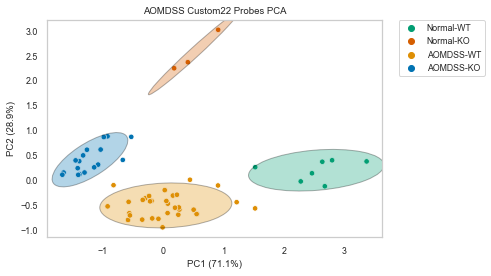

In [37]:
"""
Mouse AOMDSS Heatmap Custom22 Probes -- PCA
"""
xp.pca(aomdss_scaled, aomdss_info, palette=aomdss_colors, order_legend=[3,4,2,1], n_components=2,
        gene_list=custom22_human, whitegrid=True, grid=False,
       save_scree=__path__ + 'plots/AOMDSS_custom22_PCA_scree.pdf',
       title='AOMDSS Custom22 Probes PCA', 
        save_fig=__path__ + 'plots/AOMDSS_custom22_2CI_PCA.pdf')

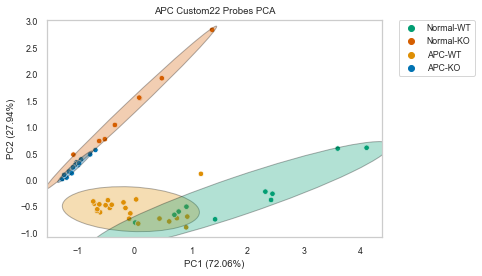

In [38]:
"""
Mouse APC Heatmap Custom22 Probes -- PCA
"""
xp.pca(apc_scaled, apc_info, palette=apc_colors, order_legend=[2,3,1,4], n_components=2,
        gene_list=custom22_human, whitegrid=True, grid=False,
       save_scree=__path__ + 'plots/APC_custom22_PCA_scree.pdf',
       title='APC Custom22 Probes PCA', 
        save_fig=__path__ + 'plots/APC_custom22_2CI_PCA.pdf')

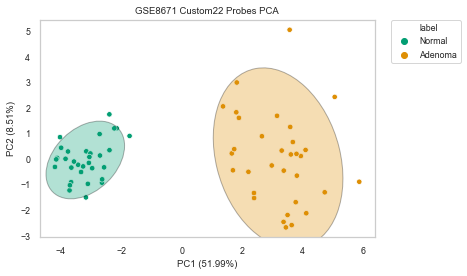

In [39]:
"""
Human GSE8671 Custom22 Probes -- PCA
"""
xp.pca(df_GSE8671_scaled, info_GSE8671, palette=gse8671_colors, n_components=2,
        gene_list=custom22_human, whitegrid=True, grid=False,
       save_scree=__path__ + 'plots/GSE8671_custom22_PCA_scree.pdf',
       title='GSE8671 Custom22 Probes PCA', 
        save_fig=__path__ + 'plots/GSE8671_custom22_2CI_PCA.pdf')

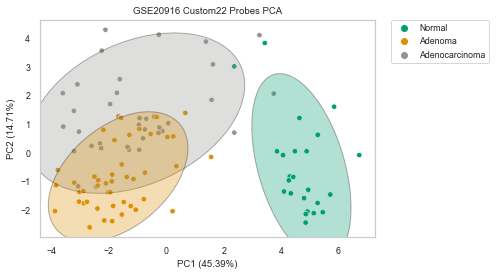

In [40]:
"""
Human GSE20916 Custom22 Probes -- PCA
"""
xp.pca(df_GSE20916_scaled, info_GSE20916, palette=gse20916_colors, order_legend=[1,3,2], n_components=2,
        gene_list=custom22_human, whitegrid=True, grid=False,
       save_scree=__path__ + 'plots/GSE20916_custom22_PCA_scree.pdf',
       title='GSE20916 Custom22 Probes PCA', 
        save_fig=__path__ + 'plots/GSE20916_custom22_2CI_PCA.pdf')

<Figure size 432x288 with 0 Axes>

<Figure size 720x720 with 0 Axes>

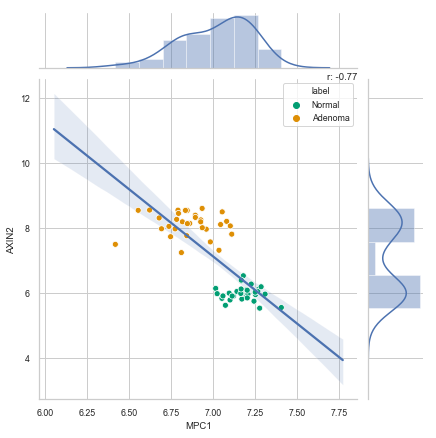

<Figure size 432x288 with 0 Axes>

In [41]:
"""
Human GSE8671 Jointplots -- MPC1 vs AXIN2
"""
xp.jointplot(df_GSE8671_collapsed, info_GSE8671, 'MPC1', 'AXIN2', palette=gse8671_colors, 
              order=['Normal','Adenoma'],
              save_fig=__path__ + 'plots/GSE8671_MPC1_AXIN2_jointplot.pdf', 
              dpi=600, bbox_inches='tight', whitegrid=True, grid=True)

<Figure size 432x288 with 0 Axes>

<Figure size 720x720 with 0 Axes>

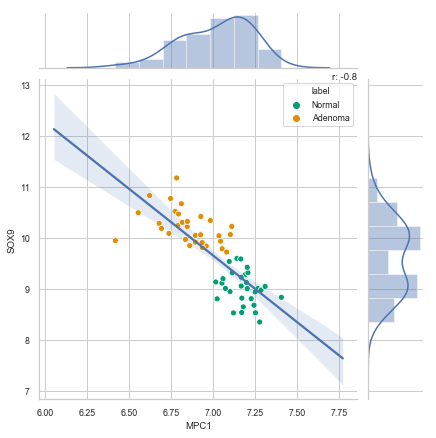

<Figure size 432x288 with 0 Axes>

In [42]:
"""
Human GSE8671 Jointplots -- MPC1 vs SOX9
"""
xp.jointplot(df_GSE8671_collapsed, info_GSE8671, 'MPC1', 'SOX9', palette=gse8671_colors, 
              order=['Normal','Adenoma'],
              save_fig=__path__ + 'plots/GSE8671_MPC1_SOX9_jointplot.pdf', 
              dpi=600, bbox_inches='tight', whitegrid=True, grid=True)

<Figure size 432x288 with 0 Axes>

<Figure size 720x720 with 0 Axes>

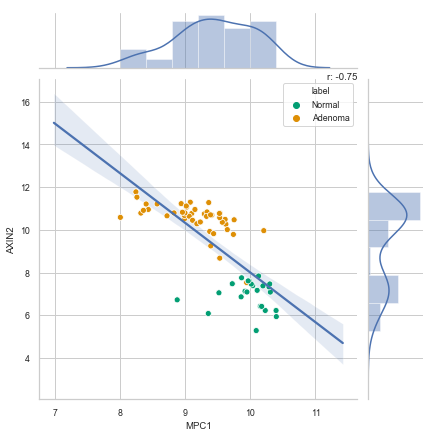

<Figure size 432x288 with 0 Axes>

In [43]:
"""
Human GSE20916 Jointplots -- MPC1 vs AXIN2, no adenocarcinomas
"""
xp.jointplot(df_GSE20916_collapsed_noac, info_GSE20916, 'MPC1', 'AXIN2', palette=gse20916_colors, 
              order=['Normal','Adenoma'],
              save_fig=__path__ + 'plots/GSE20916_MPC1_AXIN2_jointplot.pdf', 
              dpi=600, bbox_inches='tight', whitegrid=True, grid=True)

<Figure size 432x288 with 0 Axes>

<Figure size 720x720 with 0 Axes>

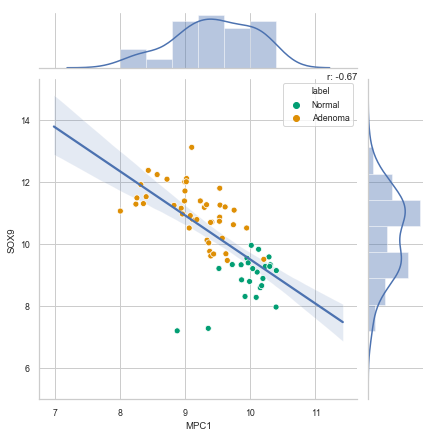

<Figure size 432x288 with 0 Axes>

In [44]:
"""
Human GSE20916 Jointplots -- MPC1 vs SOX9, no adenocarcinomas
"""
xp.jointplot(df_GSE20916_collapsed_noac, info_GSE20916, 'MPC1', 'SOX9', palette=gse20916_colors, 
              order=['Normal','Adenoma'],
              save_fig=__path__ + 'plots/GSE20916_MPC1_SOX9_jointplot.pdf', 
              dpi=600, bbox_inches='tight', whitegrid=True, grid=True)

<Figure size 432x288 with 0 Axes>

<Figure size 720x720 with 0 Axes>

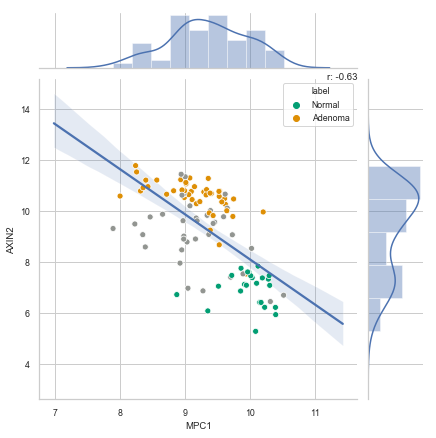

<Figure size 432x288 with 0 Axes>

In [45]:
"""
Human GSE20916 Jointplots -- MPC1 vs AXIN2
"""
xp.jointplot(df_GSE20916_collapsed, info_GSE20916, 'MPC1', 'AXIN2', palette=gse20916_colors, 
              order=['Normal','Adenoma'],
              save_fig=__path__ + 'plots/GSE20916_MPC1_AXIN2_jointplot.pdf', 
              dpi=600, bbox_inches='tight', whitegrid=True, grid=True)

<Figure size 432x288 with 0 Axes>

<Figure size 720x720 with 0 Axes>

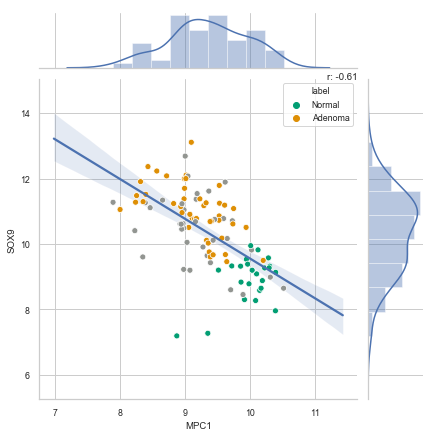

<Figure size 432x288 with 0 Axes>

In [46]:
"""
Human GSE20916 Jointplots -- MPC1 vs SOX9
"""
xp.jointplot(df_GSE20916_collapsed, info_GSE20916, 'MPC1', 'SOX9', palette=gse20916_colors, 
              order=['Normal','Adenoma'],
              save_fig=__path__ + 'plots/GSE20916_MPC1_SOX9_jointplot.pdf', 
              dpi=600, bbox_inches='tight', whitegrid=True, grid=True)

## Microarray Correlations

In [47]:
def add_fdr(file):
    
    data = pd.read_csv(
        file,
        sep=',')
    p_vals = data['p_value'].values.tolist()
    fdr = multipletests(p_vals, alpha=0.05, method='fdr_bh')
    data['fdr'] = fdr[1]
    
    data.to_csv(file)

    
#GSE20916/MPC1/ALL
xp.linreg(df_GSE20916_collapsed, 'MPC1', __path__ + 'data/GSE20916_MPC1_ALL_correlations.csv')
add_fdr(__path__ + 'data/GSE20916_MPC1_ALL_correlations.csv')

#GSE20916/MPC2/ALL
xp.linreg(df_GSE20916_collapsed, 'MPC2', __path__ + 'data/GSE20916_MPC2_ALL_correlations.csv')
add_fdr(__path__ + 'data/GSE20916_MPC2_ALL_correlations.csv')

#GSE20916/MPC1/NoAdenocarcinoma
df_GSE20916_collapsed_noAC = xp.drop_label(df_GSE20916_collapsed, info_GSE20916, 'Adenocarcinoma')
xp.linreg(df_GSE20916_collapsed_noAC, 'MPC1', __path__ + 'data/GSE20916_MPC1_noAC_correlations.csv')
add_fdr(__path__ + 'data/GSE20916_MPC1_noAC_correlations.csv')

#GSE20916/MPC2/NoAdenocarcinoma
df_GSE20916_collapsed_noAC = xp.drop_label(df_GSE20916_collapsed, info_GSE20916, 'Adenocarcinoma')
xp.linreg(df_GSE20916_collapsed_noAC, 'MPC2', __path__ + 'data/GSE20916_MPC2_noAC_correlations.csv')
add_fdr(__path__ + 'data/GSE20916_MPC2_noAC_correlations.csv')

#GSE8671/MPC1/ALL
xp.linreg(df_GSE8671_collapsed, 'MPC1', __path__ + 'data/GSE8671_MPC1_ALL_correlations.csv')
add_fdr(__path__ + 'data/GSE8671_MPC1_ALL_correlations.csv')

#GSE8671/MPC2/ALL
xp.linreg(df_GSE8671_collapsed, 'MPC2', __path__ + 'data/GSE8671_MPC2_ALL_correlations.csv')
add_fdr(__path__ + 'data/GSE8671_MPC2_ALL_correlations.csv')

## TCGA GTEx Survey of MPC and LDH Expression
See doi: 10.1038/sdata.2018.61   
Samples with z-score for gene set > 5 were excluded from heatmap to avoid signal swamp-out

In [48]:
# Import TCGA/GTEx Unity Data 

data_dir = '/Users/jordan/Desktop/project_trix/unified_data/unified_normalized/'
file_list = ['colon-rsem-fpkm-gtex.txt',
            'coad-rsem-fpkm-tcga.txt',
            'coad-rsem-fpkm-tcga-t.txt']
file_list = [str(data_dir) + str(x) for x in file_list]

#Initialize
df_list = []
meta = pd.DataFrame(columns = [0,1])
previous = 0
label_number = 0
drop_extra='Entrez_Gene_Id'
label_list = [
    'GTEX_Normal',
    'TCGA_Normal',
    'TCGA_Tumor']

#Import
for x in range(len(file_list)):

    #Get and clean data
    data = pd.read_csv(
        str(file_list[x]),
        index_col = 0,
        sep = '\t')
    del data.index.name

    #Drop extra column if needed
    if drop_extra != None:
        data = data.drop(labels=['Entrez_Gene_Id'], axis=1)

    #Add data to data list
    df_list.append(data)

    print('Size of ' + str(file_list[x]) + ': ' + str(data.shape))

    #Get metadata for current data matrix
    data_L = data.columns.tolist()

    for x in range(len(data_L)):
        meta.loc[previous + x] = [data_L[x], label_list[label_number]]

    #Update iterators
    previous = previous + len(data_L)
    label_number += 1

#Join dataframes
data = pd.concat(df_list, axis=1)
print('Size of final dataframe: ' + str(data.shape))
print('Size of final metadata table: ' + str(meta.shape))

data_scale = data.copy()
data_scale[data_scale.columns] = preprocessing.scale(data_scale[data_scale.columns], axis=1)

Size of /Users/jordan/Desktop/project_trix/unified_data/unified_normalized/colon-rsem-fpkm-gtex.txt: (19096, 339)
Size of /Users/jordan/Desktop/project_trix/unified_data/unified_normalized/coad-rsem-fpkm-tcga.txt: (19096, 41)
Size of /Users/jordan/Desktop/project_trix/unified_data/unified_normalized/coad-rsem-fpkm-tcga-t.txt: (19096, 285)
Size of final dataframe: (19096, 665)
Size of final metadata table: (665, 2)


<Figure size 432x288 with 0 Axes>

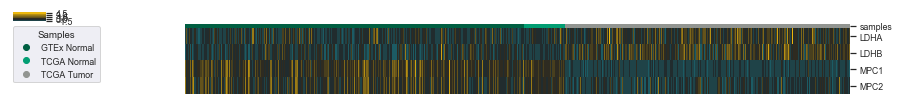

In [49]:
sample_colors = {'GTEX_Normal': '#005f42',
                 'TCGA_Normal': (0.00784313725490196, 0.6196078431372549, 0.45098039215686275),
                 'TCGA_Tumor': (0.5725490196078431, 0.5843137254901961, 0.5686274509803921)
                }

ldh = ['LDHA',
        'LDHB',
        'MPC1',
        'MPC2']
data_scale_ldh = data_scale.copy()
data_scale_ldh = data_scale_ldh.loc[ldh]

### To remove the constraint on expression magnitude, 
### remove the line below and run the code block
data_scale_ldh[data_scale_ldh > 5] = 5 # <-- Remove this one
 
xp.heatmap(
    data_scale_ldh,
    meta,
    sample_colors,
    col_cluster = False,
    xticklabels = False,
    figsize=(15,1.5))

colors = {'GTEx Normal': '#005f42',
          'TCGA Normal': (0.00784313725490196, 0.6196078431372549, 0.45098039215686275),
          'TCGA Tumor': (0.5725490196078431, 0.5843137254901961, 0.5686274509803921)
         }

g = lambda m,c: plt.plot([],[],marker='o', color=c, ls="none")[0]
handles_g = [g("s", list(colors.values())[i]) for i in range(len(list(colors.values())))]
plt.legend(handles_g, list(colors.keys()), bbox_to_anchor=(0, -7), loc=3, borderaxespad=0., title='Samples')

plt.savefig(__path__ + 'plots/tcga_mpc_ldh_heatmap.pdf',dpi=1800,bbox_inches='tight')
plt.show()

In [50]:
# TCGA effect sizes and p-values 
# https://toptipbio.com/cohens-d/
# https://stackoverflow.com/questions/21532471/how-to-calculate-cohens-d-in-python
def cohen_d(comp, base):

    cohens_d = (mean(comp) - mean(base)) / (sqrt((stdev(comp) ** 2 + stdev(base) ** 2) / 2))

    return cohens_d

#Statistical tests
data_stats = data.copy()

normal_g = meta.loc[(meta[1] == 'GTEX_Normal')][0].tolist()
normal_t = meta.loc[(meta[1] == 'TCGA_Normal')][0].tolist()
normal = normal_g + normal_t
data_norm = data_stats[normal]

data_ad = data_stats[meta.loc[meta[1] == 'TCGA_Tumor'][0].tolist()]

p_vals = []
d_vals = []
genes = data_stats.index.tolist()

total = len(genes) - 1
counter = 1

for x in genes[1:]:
    s, p = stats.ranksums(xp.get_array(data_norm, str(x)), xp.get_array(data_ad, str(x)))
    p_vals.append(p) 
    d = cohen_d(xp.get_array(data_ad, str(x)), xp.get_array(data_norm, str(x)))
    d_vals.append(d)
    print(counter,'/',total)
    counter += 1

fdr = multipletests(p_vals, alpha=0.05, method='fdr_bh')

sig_data = pd.DataFrame()
sig_data[0] = p_vals 
sig_data[1] = fdr[1]
sig_data[2] = d_vals
sig_data.index = genes[1:]



1 / 19095
2 / 19095
3 / 19095
4 / 19095
5 / 19095
6 / 19095
7 / 19095
8 / 19095
9 / 19095
10 / 19095
11 / 19095
12 / 19095
13 / 19095
14 / 19095
15 / 19095
16 / 19095
17 / 19095
18 / 19095
19 / 19095
20 / 19095
21 / 19095
22 / 19095
23 / 19095
24 / 19095
25 / 19095
26 / 19095
27 / 19095
28 / 19095
29 / 19095
30 / 19095
31 / 19095
32 / 19095
33 / 19095
34 / 19095
35 / 19095
36 / 19095
37 / 19095
38 / 19095
39 / 19095
40 / 19095
41 / 19095
42 / 19095
43 / 19095
44 / 19095
45 / 19095
46 / 19095
47 / 19095
48 / 19095
49 / 19095
50 / 19095
51 / 19095
52 / 19095
53 / 19095
54 / 19095
55 / 19095
56 / 19095
57 / 19095
58 / 19095
59 / 19095
60 / 19095
61 / 19095
62 / 19095
63 / 19095
64 / 19095
65 / 19095
66 / 19095
67 / 19095
68 / 19095
69 / 19095
70 / 19095
71 / 19095
72 / 19095
73 / 19095
74 / 19095
75 / 19095
76 / 19095
77 / 19095
78 / 19095
79 / 19095
80 / 19095
81 / 19095
82 / 19095
83 / 19095
84 / 19095
85 / 19095
86 / 19095
87 / 19095
88 / 19095
89 / 19095
90 / 19095
91 / 19095
92 / 190

693 / 19095
694 / 19095
695 / 19095
696 / 19095
697 / 19095
698 / 19095
699 / 19095
700 / 19095
701 / 19095
702 / 19095
703 / 19095
704 / 19095
705 / 19095
706 / 19095
707 / 19095
708 / 19095
709 / 19095
710 / 19095
711 / 19095
712 / 19095
713 / 19095
714 / 19095
715 / 19095
716 / 19095
717 / 19095
718 / 19095
719 / 19095
720 / 19095
721 / 19095
722 / 19095
723 / 19095
724 / 19095
725 / 19095
726 / 19095
727 / 19095
728 / 19095
729 / 19095
730 / 19095
731 / 19095
732 / 19095
733 / 19095
734 / 19095
735 / 19095
736 / 19095
737 / 19095
738 / 19095
739 / 19095
740 / 19095
741 / 19095
742 / 19095
743 / 19095
744 / 19095
745 / 19095
746 / 19095
747 / 19095
748 / 19095
749 / 19095
750 / 19095
751 / 19095
752 / 19095
753 / 19095
754 / 19095
755 / 19095
756 / 19095
757 / 19095
758 / 19095
759 / 19095
760 / 19095
761 / 19095
762 / 19095
763 / 19095
764 / 19095
765 / 19095
766 / 19095
767 / 19095
768 / 19095
769 / 19095
770 / 19095
771 / 19095
772 / 19095
773 / 19095
774 / 19095
775 / 19095
776 

1349 / 19095
1350 / 19095
1351 / 19095
1352 / 19095
1353 / 19095
1354 / 19095
1355 / 19095
1356 / 19095
1357 / 19095
1358 / 19095
1359 / 19095
1360 / 19095
1361 / 19095
1362 / 19095
1363 / 19095
1364 / 19095
1365 / 19095
1366 / 19095
1367 / 19095
1368 / 19095
1369 / 19095
1370 / 19095
1371 / 19095
1372 / 19095
1373 / 19095
1374 / 19095
1375 / 19095
1376 / 19095
1377 / 19095
1378 / 19095
1379 / 19095
1380 / 19095
1381 / 19095
1382 / 19095
1383 / 19095
1384 / 19095
1385 / 19095
1386 / 19095
1387 / 19095
1388 / 19095
1389 / 19095
1390 / 19095
1391 / 19095
1392 / 19095
1393 / 19095
1394 / 19095
1395 / 19095
1396 / 19095
1397 / 19095
1398 / 19095
1399 / 19095
1400 / 19095
1401 / 19095
1402 / 19095
1403 / 19095
1404 / 19095
1405 / 19095
1406 / 19095
1407 / 19095
1408 / 19095
1409 / 19095
1410 / 19095
1411 / 19095
1412 / 19095
1413 / 19095
1414 / 19095
1415 / 19095
1416 / 19095
1417 / 19095
1418 / 19095
1419 / 19095
1420 / 19095
1421 / 19095
1422 / 19095
1423 / 19095
1424 / 19095
1425 / 19095

1981 / 19095
1982 / 19095
1983 / 19095
1984 / 19095
1985 / 19095
1986 / 19095
1987 / 19095
1988 / 19095
1989 / 19095
1990 / 19095
1991 / 19095
1992 / 19095
1993 / 19095
1994 / 19095
1995 / 19095
1996 / 19095
1997 / 19095
1998 / 19095
1999 / 19095
2000 / 19095
2001 / 19095
2002 / 19095
2003 / 19095
2004 / 19095
2005 / 19095
2006 / 19095
2007 / 19095
2008 / 19095
2009 / 19095
2010 / 19095
2011 / 19095
2012 / 19095
2013 / 19095
2014 / 19095
2015 / 19095
2016 / 19095
2017 / 19095
2018 / 19095
2019 / 19095
2020 / 19095
2021 / 19095
2022 / 19095
2023 / 19095
2024 / 19095
2025 / 19095
2026 / 19095
2027 / 19095
2028 / 19095
2029 / 19095
2030 / 19095
2031 / 19095
2032 / 19095
2033 / 19095
2034 / 19095
2035 / 19095
2036 / 19095
2037 / 19095
2038 / 19095
2039 / 19095
2040 / 19095
2041 / 19095
2042 / 19095
2043 / 19095
2044 / 19095
2045 / 19095
2046 / 19095
2047 / 19095
2048 / 19095
2049 / 19095
2050 / 19095
2051 / 19095
2052 / 19095
2053 / 19095
2054 / 19095
2055 / 19095
2056 / 19095
2057 / 19095

2613 / 19095
2614 / 19095
2615 / 19095
2616 / 19095
2617 / 19095
2618 / 19095
2619 / 19095
2620 / 19095
2621 / 19095
2622 / 19095
2623 / 19095
2624 / 19095
2625 / 19095
2626 / 19095
2627 / 19095
2628 / 19095
2629 / 19095
2630 / 19095
2631 / 19095
2632 / 19095
2633 / 19095
2634 / 19095
2635 / 19095
2636 / 19095
2637 / 19095
2638 / 19095
2639 / 19095
2640 / 19095
2641 / 19095
2642 / 19095
2643 / 19095
2644 / 19095
2645 / 19095
2646 / 19095
2647 / 19095
2648 / 19095
2649 / 19095
2650 / 19095
2651 / 19095
2652 / 19095
2653 / 19095
2654 / 19095
2655 / 19095
2656 / 19095
2657 / 19095
2658 / 19095
2659 / 19095
2660 / 19095
2661 / 19095
2662 / 19095
2663 / 19095
2664 / 19095
2665 / 19095
2666 / 19095
2667 / 19095
2668 / 19095
2669 / 19095
2670 / 19095
2671 / 19095
2672 / 19095
2673 / 19095
2674 / 19095
2675 / 19095
2676 / 19095
2677 / 19095
2678 / 19095
2679 / 19095
2680 / 19095
2681 / 19095
2682 / 19095
2683 / 19095
2684 / 19095
2685 / 19095
2686 / 19095
2687 / 19095
2688 / 19095
2689 / 19095

3245 / 19095
3246 / 19095
3247 / 19095
3248 / 19095
3249 / 19095
3250 / 19095
3251 / 19095
3252 / 19095
3253 / 19095
3254 / 19095
3255 / 19095
3256 / 19095
3257 / 19095
3258 / 19095
3259 / 19095
3260 / 19095
3261 / 19095
3262 / 19095
3263 / 19095
3264 / 19095
3265 / 19095
3266 / 19095
3267 / 19095
3268 / 19095
3269 / 19095
3270 / 19095
3271 / 19095
3272 / 19095
3273 / 19095
3274 / 19095
3275 / 19095
3276 / 19095
3277 / 19095
3278 / 19095
3279 / 19095
3280 / 19095
3281 / 19095
3282 / 19095
3283 / 19095
3284 / 19095
3285 / 19095
3286 / 19095
3287 / 19095
3288 / 19095
3289 / 19095
3290 / 19095
3291 / 19095
3292 / 19095
3293 / 19095
3294 / 19095
3295 / 19095
3296 / 19095
3297 / 19095
3298 / 19095
3299 / 19095
3300 / 19095
3301 / 19095
3302 / 19095
3303 / 19095
3304 / 19095
3305 / 19095
3306 / 19095
3307 / 19095
3308 / 19095
3309 / 19095
3310 / 19095
3311 / 19095
3312 / 19095
3313 / 19095
3314 / 19095
3315 / 19095
3316 / 19095
3317 / 19095
3318 / 19095
3319 / 19095
3320 / 19095
3321 / 19095

3877 / 19095
3878 / 19095
3879 / 19095
3880 / 19095
3881 / 19095
3882 / 19095
3883 / 19095
3884 / 19095
3885 / 19095
3886 / 19095
3887 / 19095
3888 / 19095
3889 / 19095
3890 / 19095
3891 / 19095
3892 / 19095
3893 / 19095
3894 / 19095
3895 / 19095
3896 / 19095
3897 / 19095
3898 / 19095
3899 / 19095
3900 / 19095
3901 / 19095
3902 / 19095
3903 / 19095
3904 / 19095
3905 / 19095
3906 / 19095
3907 / 19095
3908 / 19095
3909 / 19095
3910 / 19095
3911 / 19095
3912 / 19095
3913 / 19095
3914 / 19095
3915 / 19095
3916 / 19095
3917 / 19095
3918 / 19095
3919 / 19095
3920 / 19095
3921 / 19095
3922 / 19095
3923 / 19095
3924 / 19095
3925 / 19095
3926 / 19095
3927 / 19095
3928 / 19095
3929 / 19095
3930 / 19095
3931 / 19095
3932 / 19095
3933 / 19095
3934 / 19095
3935 / 19095
3936 / 19095
3937 / 19095
3938 / 19095
3939 / 19095
3940 / 19095
3941 / 19095
3942 / 19095
3943 / 19095
3944 / 19095
3945 / 19095
3946 / 19095
3947 / 19095
3948 / 19095
3949 / 19095
3950 / 19095
3951 / 19095
3952 / 19095
3953 / 19095

4509 / 19095
4510 / 19095
4511 / 19095
4512 / 19095
4513 / 19095
4514 / 19095
4515 / 19095
4516 / 19095
4517 / 19095
4518 / 19095
4519 / 19095
4520 / 19095
4521 / 19095
4522 / 19095
4523 / 19095
4524 / 19095
4525 / 19095
4526 / 19095
4527 / 19095
4528 / 19095
4529 / 19095
4530 / 19095
4531 / 19095
4532 / 19095
4533 / 19095
4534 / 19095
4535 / 19095
4536 / 19095
4537 / 19095
4538 / 19095
4539 / 19095
4540 / 19095
4541 / 19095
4542 / 19095
4543 / 19095
4544 / 19095
4545 / 19095
4546 / 19095
4547 / 19095
4548 / 19095
4549 / 19095
4550 / 19095
4551 / 19095
4552 / 19095
4553 / 19095
4554 / 19095
4555 / 19095
4556 / 19095
4557 / 19095
4558 / 19095
4559 / 19095
4560 / 19095
4561 / 19095
4562 / 19095
4563 / 19095
4564 / 19095
4565 / 19095
4566 / 19095
4567 / 19095
4568 / 19095
4569 / 19095
4570 / 19095
4571 / 19095
4572 / 19095
4573 / 19095
4574 / 19095
4575 / 19095
4576 / 19095
4577 / 19095
4578 / 19095
4579 / 19095
4580 / 19095
4581 / 19095
4582 / 19095
4583 / 19095
4584 / 19095
4585 / 19095

5141 / 19095
5142 / 19095
5143 / 19095
5144 / 19095
5145 / 19095
5146 / 19095
5147 / 19095
5148 / 19095
5149 / 19095
5150 / 19095
5151 / 19095
5152 / 19095
5153 / 19095
5154 / 19095
5155 / 19095
5156 / 19095
5157 / 19095
5158 / 19095
5159 / 19095
5160 / 19095
5161 / 19095
5162 / 19095
5163 / 19095
5164 / 19095
5165 / 19095
5166 / 19095
5167 / 19095
5168 / 19095
5169 / 19095
5170 / 19095
5171 / 19095
5172 / 19095
5173 / 19095
5174 / 19095
5175 / 19095
5176 / 19095
5177 / 19095
5178 / 19095
5179 / 19095
5180 / 19095
5181 / 19095
5182 / 19095
5183 / 19095
5184 / 19095
5185 / 19095
5186 / 19095
5187 / 19095
5188 / 19095
5189 / 19095
5190 / 19095
5191 / 19095
5192 / 19095
5193 / 19095
5194 / 19095
5195 / 19095
5196 / 19095
5197 / 19095
5198 / 19095
5199 / 19095
5200 / 19095
5201 / 19095
5202 / 19095
5203 / 19095
5204 / 19095
5205 / 19095
5206 / 19095
5207 / 19095
5208 / 19095
5209 / 19095
5210 / 19095
5211 / 19095
5212 / 19095
5213 / 19095
5214 / 19095
5215 / 19095
5216 / 19095
5217 / 19095

5773 / 19095
5774 / 19095
5775 / 19095
5776 / 19095
5777 / 19095
5778 / 19095
5779 / 19095
5780 / 19095
5781 / 19095
5782 / 19095
5783 / 19095
5784 / 19095
5785 / 19095
5786 / 19095
5787 / 19095
5788 / 19095
5789 / 19095
5790 / 19095
5791 / 19095
5792 / 19095
5793 / 19095
5794 / 19095
5795 / 19095
5796 / 19095
5797 / 19095
5798 / 19095
5799 / 19095
5800 / 19095
5801 / 19095
5802 / 19095
5803 / 19095
5804 / 19095
5805 / 19095
5806 / 19095
5807 / 19095
5808 / 19095
5809 / 19095
5810 / 19095
5811 / 19095
5812 / 19095
5813 / 19095
5814 / 19095
5815 / 19095
5816 / 19095
5817 / 19095
5818 / 19095
5819 / 19095
5820 / 19095
5821 / 19095
5822 / 19095
5823 / 19095
5824 / 19095
5825 / 19095
5826 / 19095
5827 / 19095
5828 / 19095
5829 / 19095
5830 / 19095
5831 / 19095
5832 / 19095
5833 / 19095
5834 / 19095
5835 / 19095
5836 / 19095
5837 / 19095
5838 / 19095
5839 / 19095
5840 / 19095
5841 / 19095
5842 / 19095
5843 / 19095
5844 / 19095
5845 / 19095
5846 / 19095
5847 / 19095
5848 / 19095
5849 / 19095

6405 / 19095
6406 / 19095
6407 / 19095
6408 / 19095
6409 / 19095
6410 / 19095
6411 / 19095
6412 / 19095
6413 / 19095
6414 / 19095
6415 / 19095
6416 / 19095
6417 / 19095
6418 / 19095
6419 / 19095
6420 / 19095
6421 / 19095
6422 / 19095
6423 / 19095
6424 / 19095
6425 / 19095
6426 / 19095
6427 / 19095
6428 / 19095
6429 / 19095
6430 / 19095
6431 / 19095
6432 / 19095
6433 / 19095
6434 / 19095
6435 / 19095
6436 / 19095
6437 / 19095
6438 / 19095
6439 / 19095
6440 / 19095
6441 / 19095
6442 / 19095
6443 / 19095
6444 / 19095
6445 / 19095
6446 / 19095
6447 / 19095
6448 / 19095
6449 / 19095
6450 / 19095
6451 / 19095
6452 / 19095
6453 / 19095
6454 / 19095
6455 / 19095
6456 / 19095
6457 / 19095
6458 / 19095
6459 / 19095
6460 / 19095
6461 / 19095
6462 / 19095
6463 / 19095
6464 / 19095
6465 / 19095
6466 / 19095
6467 / 19095
6468 / 19095
6469 / 19095
6470 / 19095
6471 / 19095
6472 / 19095
6473 / 19095
6474 / 19095
6475 / 19095
6476 / 19095
6477 / 19095
6478 / 19095
6479 / 19095
6480 / 19095
6481 / 19095

7037 / 19095
7038 / 19095
7039 / 19095
7040 / 19095
7041 / 19095
7042 / 19095
7043 / 19095
7044 / 19095
7045 / 19095
7046 / 19095
7047 / 19095
7048 / 19095
7049 / 19095
7050 / 19095
7051 / 19095
7052 / 19095
7053 / 19095
7054 / 19095
7055 / 19095
7056 / 19095
7057 / 19095
7058 / 19095
7059 / 19095
7060 / 19095
7061 / 19095
7062 / 19095
7063 / 19095
7064 / 19095
7065 / 19095
7066 / 19095
7067 / 19095
7068 / 19095
7069 / 19095
7070 / 19095
7071 / 19095
7072 / 19095
7073 / 19095
7074 / 19095
7075 / 19095
7076 / 19095
7077 / 19095
7078 / 19095
7079 / 19095
7080 / 19095
7081 / 19095
7082 / 19095
7083 / 19095
7084 / 19095
7085 / 19095
7086 / 19095
7087 / 19095
7088 / 19095
7089 / 19095
7090 / 19095
7091 / 19095
7092 / 19095
7093 / 19095
7094 / 19095
7095 / 19095
7096 / 19095
7097 / 19095
7098 / 19095
7099 / 19095
7100 / 19095
7101 / 19095
7102 / 19095
7103 / 19095
7104 / 19095
7105 / 19095
7106 / 19095
7107 / 19095
7108 / 19095
7109 / 19095
7110 / 19095
7111 / 19095
7112 / 19095
7113 / 19095

7669 / 19095
7670 / 19095
7671 / 19095
7672 / 19095
7673 / 19095
7674 / 19095
7675 / 19095
7676 / 19095
7677 / 19095
7678 / 19095
7679 / 19095
7680 / 19095
7681 / 19095
7682 / 19095
7683 / 19095
7684 / 19095
7685 / 19095
7686 / 19095
7687 / 19095
7688 / 19095
7689 / 19095
7690 / 19095
7691 / 19095
7692 / 19095
7693 / 19095
7694 / 19095
7695 / 19095
7696 / 19095
7697 / 19095
7698 / 19095
7699 / 19095
7700 / 19095
7701 / 19095
7702 / 19095
7703 / 19095
7704 / 19095
7705 / 19095
7706 / 19095
7707 / 19095
7708 / 19095
7709 / 19095
7710 / 19095
7711 / 19095
7712 / 19095
7713 / 19095
7714 / 19095
7715 / 19095
7716 / 19095
7717 / 19095
7718 / 19095
7719 / 19095
7720 / 19095
7721 / 19095
7722 / 19095
7723 / 19095
7724 / 19095
7725 / 19095
7726 / 19095
7727 / 19095
7728 / 19095
7729 / 19095
7730 / 19095
7731 / 19095
7732 / 19095
7733 / 19095
7734 / 19095
7735 / 19095
7736 / 19095
7737 / 19095
7738 / 19095
7739 / 19095
7740 / 19095
7741 / 19095
7742 / 19095
7743 / 19095
7744 / 19095
7745 / 19095

8301 / 19095
8302 / 19095
8303 / 19095
8304 / 19095
8305 / 19095
8306 / 19095
8307 / 19095
8308 / 19095
8309 / 19095
8310 / 19095
8311 / 19095
8312 / 19095
8313 / 19095
8314 / 19095
8315 / 19095
8316 / 19095
8317 / 19095
8318 / 19095
8319 / 19095
8320 / 19095
8321 / 19095
8322 / 19095
8323 / 19095
8324 / 19095
8325 / 19095
8326 / 19095
8327 / 19095
8328 / 19095
8329 / 19095
8330 / 19095
8331 / 19095
8332 / 19095
8333 / 19095
8334 / 19095
8335 / 19095
8336 / 19095
8337 / 19095
8338 / 19095
8339 / 19095
8340 / 19095
8341 / 19095
8342 / 19095
8343 / 19095
8344 / 19095
8345 / 19095
8346 / 19095
8347 / 19095
8348 / 19095
8349 / 19095
8350 / 19095
8351 / 19095
8352 / 19095
8353 / 19095
8354 / 19095
8355 / 19095
8356 / 19095
8357 / 19095
8358 / 19095
8359 / 19095
8360 / 19095
8361 / 19095
8362 / 19095
8363 / 19095
8364 / 19095
8365 / 19095
8366 / 19095
8367 / 19095
8368 / 19095
8369 / 19095
8370 / 19095
8371 / 19095
8372 / 19095
8373 / 19095
8374 / 19095
8375 / 19095
8376 / 19095
8377 / 19095

8932 / 19095
8933 / 19095
8934 / 19095
8935 / 19095
8936 / 19095
8937 / 19095
8938 / 19095
8939 / 19095
8940 / 19095
8941 / 19095
8942 / 19095
8943 / 19095
8944 / 19095
8945 / 19095
8946 / 19095
8947 / 19095
8948 / 19095
8949 / 19095
8950 / 19095
8951 / 19095
8952 / 19095
8953 / 19095
8954 / 19095
8955 / 19095
8956 / 19095
8957 / 19095
8958 / 19095
8959 / 19095
8960 / 19095
8961 / 19095
8962 / 19095
8963 / 19095
8964 / 19095
8965 / 19095
8966 / 19095
8967 / 19095
8968 / 19095
8969 / 19095
8970 / 19095
8971 / 19095
8972 / 19095
8973 / 19095
8974 / 19095
8975 / 19095
8976 / 19095
8977 / 19095
8978 / 19095
8979 / 19095
8980 / 19095
8981 / 19095
8982 / 19095
8983 / 19095
8984 / 19095
8985 / 19095
8986 / 19095
8987 / 19095
8988 / 19095
8989 / 19095
8990 / 19095
8991 / 19095
8992 / 19095
8993 / 19095
8994 / 19095
8995 / 19095
8996 / 19095
8997 / 19095
8998 / 19095
8999 / 19095
9000 / 19095
9001 / 19095
9002 / 19095
9003 / 19095
9004 / 19095
9005 / 19095
9006 / 19095
9007 / 19095
9008 / 19095

9563 / 19095
9564 / 19095
9565 / 19095
9566 / 19095
9567 / 19095
9568 / 19095
9569 / 19095
9570 / 19095
9571 / 19095
9572 / 19095
9573 / 19095
9574 / 19095
9575 / 19095
9576 / 19095
9577 / 19095
9578 / 19095
9579 / 19095
9580 / 19095
9581 / 19095
9582 / 19095
9583 / 19095
9584 / 19095
9585 / 19095
9586 / 19095
9587 / 19095
9588 / 19095
9589 / 19095
9590 / 19095
9591 / 19095
9592 / 19095
9593 / 19095
9594 / 19095
9595 / 19095
9596 / 19095
9597 / 19095
9598 / 19095
9599 / 19095
9600 / 19095
9601 / 19095
9602 / 19095
9603 / 19095
9604 / 19095
9605 / 19095
9606 / 19095
9607 / 19095
9608 / 19095
9609 / 19095
9610 / 19095
9611 / 19095
9612 / 19095
9613 / 19095
9614 / 19095
9615 / 19095
9616 / 19095
9617 / 19095
9618 / 19095
9619 / 19095
9620 / 19095
9621 / 19095
9622 / 19095
9623 / 19095
9624 / 19095
9625 / 19095
9626 / 19095
9627 / 19095
9628 / 19095
9629 / 19095
9630 / 19095
9631 / 19095
9632 / 19095
9633 / 19095
9634 / 19095
9635 / 19095
9636 / 19095
9637 / 19095
9638 / 19095
9639 / 19095

10183 / 19095
10184 / 19095
10185 / 19095
10186 / 19095
10187 / 19095
10188 / 19095
10189 / 19095
10190 / 19095
10191 / 19095
10192 / 19095
10193 / 19095
10194 / 19095
10195 / 19095
10196 / 19095
10197 / 19095
10198 / 19095
10199 / 19095
10200 / 19095
10201 / 19095
10202 / 19095
10203 / 19095
10204 / 19095
10205 / 19095
10206 / 19095
10207 / 19095
10208 / 19095
10209 / 19095
10210 / 19095
10211 / 19095
10212 / 19095
10213 / 19095
10214 / 19095
10215 / 19095
10216 / 19095
10217 / 19095
10218 / 19095
10219 / 19095
10220 / 19095
10221 / 19095
10222 / 19095
10223 / 19095
10224 / 19095
10225 / 19095
10226 / 19095
10227 / 19095
10228 / 19095
10229 / 19095
10230 / 19095
10231 / 19095
10232 / 19095
10233 / 19095
10234 / 19095
10235 / 19095
10236 / 19095
10237 / 19095
10238 / 19095
10239 / 19095
10240 / 19095
10241 / 19095
10242 / 19095
10243 / 19095
10244 / 19095
10245 / 19095
10246 / 19095
10247 / 19095
10248 / 19095
10249 / 19095
10250 / 19095
10251 / 19095
10252 / 19095
10253 / 19095
10254 

10771 / 19095
10772 / 19095
10773 / 19095
10774 / 19095
10775 / 19095
10776 / 19095
10777 / 19095
10778 / 19095
10779 / 19095
10780 / 19095
10781 / 19095
10782 / 19095
10783 / 19095
10784 / 19095
10785 / 19095
10786 / 19095
10787 / 19095
10788 / 19095
10789 / 19095
10790 / 19095
10791 / 19095
10792 / 19095
10793 / 19095
10794 / 19095
10795 / 19095
10796 / 19095
10797 / 19095
10798 / 19095
10799 / 19095
10800 / 19095
10801 / 19095
10802 / 19095
10803 / 19095
10804 / 19095
10805 / 19095
10806 / 19095
10807 / 19095
10808 / 19095
10809 / 19095
10810 / 19095
10811 / 19095
10812 / 19095
10813 / 19095
10814 / 19095
10815 / 19095
10816 / 19095
10817 / 19095
10818 / 19095
10819 / 19095
10820 / 19095
10821 / 19095
10822 / 19095
10823 / 19095
10824 / 19095
10825 / 19095
10826 / 19095
10827 / 19095
10828 / 19095
10829 / 19095
10830 / 19095
10831 / 19095
10832 / 19095
10833 / 19095
10834 / 19095
10835 / 19095
10836 / 19095
10837 / 19095
10838 / 19095
10839 / 19095
10840 / 19095
10841 / 19095
10842 

11359 / 19095
11360 / 19095
11361 / 19095
11362 / 19095
11363 / 19095
11364 / 19095
11365 / 19095
11366 / 19095
11367 / 19095
11368 / 19095
11369 / 19095
11370 / 19095
11371 / 19095
11372 / 19095
11373 / 19095
11374 / 19095
11375 / 19095
11376 / 19095
11377 / 19095
11378 / 19095
11379 / 19095
11380 / 19095
11381 / 19095
11382 / 19095
11383 / 19095
11384 / 19095
11385 / 19095
11386 / 19095
11387 / 19095
11388 / 19095
11389 / 19095
11390 / 19095
11391 / 19095
11392 / 19095
11393 / 19095
11394 / 19095
11395 / 19095
11396 / 19095
11397 / 19095
11398 / 19095
11399 / 19095
11400 / 19095
11401 / 19095
11402 / 19095
11403 / 19095
11404 / 19095
11405 / 19095
11406 / 19095
11407 / 19095
11408 / 19095
11409 / 19095
11410 / 19095
11411 / 19095
11412 / 19095
11413 / 19095
11414 / 19095
11415 / 19095
11416 / 19095
11417 / 19095
11418 / 19095
11419 / 19095
11420 / 19095
11421 / 19095
11422 / 19095
11423 / 19095
11424 / 19095
11425 / 19095
11426 / 19095
11427 / 19095
11428 / 19095
11429 / 19095
11430 

11947 / 19095
11948 / 19095
11949 / 19095
11950 / 19095
11951 / 19095
11952 / 19095
11953 / 19095
11954 / 19095
11955 / 19095
11956 / 19095
11957 / 19095
11958 / 19095
11959 / 19095
11960 / 19095
11961 / 19095
11962 / 19095
11963 / 19095
11964 / 19095
11965 / 19095
11966 / 19095
11967 / 19095
11968 / 19095
11969 / 19095
11970 / 19095
11971 / 19095
11972 / 19095
11973 / 19095
11974 / 19095
11975 / 19095
11976 / 19095
11977 / 19095
11978 / 19095
11979 / 19095
11980 / 19095
11981 / 19095
11982 / 19095
11983 / 19095
11984 / 19095
11985 / 19095
11986 / 19095
11987 / 19095
11988 / 19095
11989 / 19095
11990 / 19095
11991 / 19095
11992 / 19095
11993 / 19095
11994 / 19095
11995 / 19095
11996 / 19095
11997 / 19095
11998 / 19095
11999 / 19095
12000 / 19095
12001 / 19095
12002 / 19095
12003 / 19095
12004 / 19095
12005 / 19095
12006 / 19095
12007 / 19095
12008 / 19095
12009 / 19095
12010 / 19095
12011 / 19095
12012 / 19095
12013 / 19095
12014 / 19095
12015 / 19095
12016 / 19095
12017 / 19095
12018 

12535 / 19095
12536 / 19095
12537 / 19095
12538 / 19095
12539 / 19095
12540 / 19095
12541 / 19095
12542 / 19095
12543 / 19095
12544 / 19095
12545 / 19095
12546 / 19095
12547 / 19095
12548 / 19095
12549 / 19095
12550 / 19095
12551 / 19095
12552 / 19095
12553 / 19095
12554 / 19095
12555 / 19095
12556 / 19095
12557 / 19095
12558 / 19095
12559 / 19095
12560 / 19095
12561 / 19095
12562 / 19095
12563 / 19095
12564 / 19095
12565 / 19095
12566 / 19095
12567 / 19095
12568 / 19095
12569 / 19095
12570 / 19095
12571 / 19095
12572 / 19095
12573 / 19095
12574 / 19095
12575 / 19095
12576 / 19095
12577 / 19095
12578 / 19095
12579 / 19095
12580 / 19095
12581 / 19095
12582 / 19095
12583 / 19095
12584 / 19095
12585 / 19095
12586 / 19095
12587 / 19095
12588 / 19095
12589 / 19095
12590 / 19095
12591 / 19095
12592 / 19095
12593 / 19095
12594 / 19095
12595 / 19095
12596 / 19095
12597 / 19095
12598 / 19095
12599 / 19095
12600 / 19095
12601 / 19095
12602 / 19095
12603 / 19095
12604 / 19095
12605 / 19095
12606 

13123 / 19095
13124 / 19095
13125 / 19095
13126 / 19095
13127 / 19095
13128 / 19095
13129 / 19095
13130 / 19095
13131 / 19095
13132 / 19095
13133 / 19095
13134 / 19095
13135 / 19095
13136 / 19095
13137 / 19095
13138 / 19095
13139 / 19095
13140 / 19095
13141 / 19095
13142 / 19095
13143 / 19095
13144 / 19095
13145 / 19095
13146 / 19095
13147 / 19095
13148 / 19095
13149 / 19095
13150 / 19095
13151 / 19095
13152 / 19095
13153 / 19095
13154 / 19095
13155 / 19095
13156 / 19095
13157 / 19095
13158 / 19095
13159 / 19095
13160 / 19095
13161 / 19095
13162 / 19095
13163 / 19095
13164 / 19095
13165 / 19095
13166 / 19095
13167 / 19095
13168 / 19095
13169 / 19095
13170 / 19095
13171 / 19095
13172 / 19095
13173 / 19095
13174 / 19095
13175 / 19095
13176 / 19095
13177 / 19095
13178 / 19095
13179 / 19095
13180 / 19095
13181 / 19095
13182 / 19095
13183 / 19095
13184 / 19095
13185 / 19095
13186 / 19095
13187 / 19095
13188 / 19095
13189 / 19095
13190 / 19095
13191 / 19095
13192 / 19095
13193 / 19095
13194 

13711 / 19095
13712 / 19095
13713 / 19095
13714 / 19095
13715 / 19095
13716 / 19095
13717 / 19095
13718 / 19095
13719 / 19095
13720 / 19095
13721 / 19095
13722 / 19095
13723 / 19095
13724 / 19095
13725 / 19095
13726 / 19095
13727 / 19095
13728 / 19095
13729 / 19095
13730 / 19095
13731 / 19095
13732 / 19095
13733 / 19095
13734 / 19095
13735 / 19095
13736 / 19095
13737 / 19095
13738 / 19095
13739 / 19095
13740 / 19095
13741 / 19095
13742 / 19095
13743 / 19095
13744 / 19095
13745 / 19095
13746 / 19095
13747 / 19095
13748 / 19095
13749 / 19095
13750 / 19095
13751 / 19095
13752 / 19095
13753 / 19095
13754 / 19095
13755 / 19095
13756 / 19095
13757 / 19095
13758 / 19095
13759 / 19095
13760 / 19095
13761 / 19095
13762 / 19095
13763 / 19095
13764 / 19095
13765 / 19095
13766 / 19095
13767 / 19095
13768 / 19095
13769 / 19095
13770 / 19095
13771 / 19095
13772 / 19095
13773 / 19095
13774 / 19095
13775 / 19095
13776 / 19095
13777 / 19095
13778 / 19095
13779 / 19095
13780 / 19095
13781 / 19095
13782 

14299 / 19095
14300 / 19095
14301 / 19095
14302 / 19095
14303 / 19095
14304 / 19095
14305 / 19095
14306 / 19095
14307 / 19095
14308 / 19095
14309 / 19095
14310 / 19095
14311 / 19095
14312 / 19095
14313 / 19095
14314 / 19095
14315 / 19095
14316 / 19095
14317 / 19095
14318 / 19095
14319 / 19095
14320 / 19095
14321 / 19095
14322 / 19095
14323 / 19095
14324 / 19095
14325 / 19095
14326 / 19095
14327 / 19095
14328 / 19095
14329 / 19095
14330 / 19095
14331 / 19095
14332 / 19095
14333 / 19095
14334 / 19095
14335 / 19095
14336 / 19095
14337 / 19095
14338 / 19095
14339 / 19095
14340 / 19095
14341 / 19095
14342 / 19095
14343 / 19095
14344 / 19095
14345 / 19095
14346 / 19095
14347 / 19095
14348 / 19095
14349 / 19095
14350 / 19095
14351 / 19095
14352 / 19095
14353 / 19095
14354 / 19095
14355 / 19095
14356 / 19095
14357 / 19095
14358 / 19095
14359 / 19095
14360 / 19095
14361 / 19095
14362 / 19095
14363 / 19095
14364 / 19095
14365 / 19095
14366 / 19095
14367 / 19095
14368 / 19095
14369 / 19095
14370 

14887 / 19095
14888 / 19095
14889 / 19095
14890 / 19095
14891 / 19095
14892 / 19095
14893 / 19095
14894 / 19095
14895 / 19095
14896 / 19095
14897 / 19095
14898 / 19095
14899 / 19095
14900 / 19095
14901 / 19095
14902 / 19095
14903 / 19095
14904 / 19095
14905 / 19095
14906 / 19095
14907 / 19095
14908 / 19095
14909 / 19095
14910 / 19095
14911 / 19095
14912 / 19095
14913 / 19095
14914 / 19095
14915 / 19095
14916 / 19095
14917 / 19095
14918 / 19095
14919 / 19095
14920 / 19095
14921 / 19095
14922 / 19095
14923 / 19095
14924 / 19095
14925 / 19095
14926 / 19095
14927 / 19095
14928 / 19095
14929 / 19095
14930 / 19095
14931 / 19095
14932 / 19095
14933 / 19095
14934 / 19095
14935 / 19095
14936 / 19095
14937 / 19095
14938 / 19095
14939 / 19095
14940 / 19095
14941 / 19095
14942 / 19095
14943 / 19095
14944 / 19095
14945 / 19095
14946 / 19095
14947 / 19095
14948 / 19095
14949 / 19095
14950 / 19095
14951 / 19095
14952 / 19095
14953 / 19095
14954 / 19095
14955 / 19095
14956 / 19095
14957 / 19095
14958 

15475 / 19095
15476 / 19095
15477 / 19095
15478 / 19095
15479 / 19095
15480 / 19095
15481 / 19095
15482 / 19095
15483 / 19095
15484 / 19095
15485 / 19095
15486 / 19095
15487 / 19095
15488 / 19095
15489 / 19095
15490 / 19095
15491 / 19095
15492 / 19095
15493 / 19095
15494 / 19095
15495 / 19095
15496 / 19095
15497 / 19095
15498 / 19095
15499 / 19095
15500 / 19095
15501 / 19095
15502 / 19095
15503 / 19095
15504 / 19095
15505 / 19095
15506 / 19095
15507 / 19095
15508 / 19095
15509 / 19095
15510 / 19095
15511 / 19095
15512 / 19095
15513 / 19095
15514 / 19095
15515 / 19095
15516 / 19095
15517 / 19095
15518 / 19095
15519 / 19095
15520 / 19095
15521 / 19095
15522 / 19095
15523 / 19095
15524 / 19095
15525 / 19095
15526 / 19095
15527 / 19095
15528 / 19095
15529 / 19095
15530 / 19095
15531 / 19095
15532 / 19095
15533 / 19095
15534 / 19095
15535 / 19095
15536 / 19095
15537 / 19095
15538 / 19095
15539 / 19095
15540 / 19095
15541 / 19095
15542 / 19095
15543 / 19095
15544 / 19095
15545 / 19095
15546 

16063 / 19095
16064 / 19095
16065 / 19095
16066 / 19095
16067 / 19095
16068 / 19095
16069 / 19095
16070 / 19095
16071 / 19095
16072 / 19095
16073 / 19095
16074 / 19095
16075 / 19095
16076 / 19095
16077 / 19095
16078 / 19095
16079 / 19095
16080 / 19095
16081 / 19095
16082 / 19095
16083 / 19095
16084 / 19095
16085 / 19095
16086 / 19095
16087 / 19095
16088 / 19095
16089 / 19095
16090 / 19095
16091 / 19095
16092 / 19095
16093 / 19095
16094 / 19095
16095 / 19095
16096 / 19095
16097 / 19095
16098 / 19095
16099 / 19095
16100 / 19095
16101 / 19095
16102 / 19095
16103 / 19095
16104 / 19095
16105 / 19095
16106 / 19095
16107 / 19095
16108 / 19095
16109 / 19095
16110 / 19095
16111 / 19095
16112 / 19095
16113 / 19095
16114 / 19095
16115 / 19095
16116 / 19095
16117 / 19095
16118 / 19095
16119 / 19095
16120 / 19095
16121 / 19095
16122 / 19095
16123 / 19095
16124 / 19095
16125 / 19095
16126 / 19095
16127 / 19095
16128 / 19095
16129 / 19095
16130 / 19095
16131 / 19095
16132 / 19095
16133 / 19095
16134 

16651 / 19095
16652 / 19095
16653 / 19095
16654 / 19095
16655 / 19095
16656 / 19095
16657 / 19095
16658 / 19095
16659 / 19095
16660 / 19095
16661 / 19095
16662 / 19095
16663 / 19095
16664 / 19095
16665 / 19095
16666 / 19095
16667 / 19095
16668 / 19095
16669 / 19095
16670 / 19095
16671 / 19095
16672 / 19095
16673 / 19095
16674 / 19095
16675 / 19095
16676 / 19095
16677 / 19095
16678 / 19095
16679 / 19095
16680 / 19095
16681 / 19095
16682 / 19095
16683 / 19095
16684 / 19095
16685 / 19095
16686 / 19095
16687 / 19095
16688 / 19095
16689 / 19095
16690 / 19095
16691 / 19095
16692 / 19095
16693 / 19095
16694 / 19095
16695 / 19095
16696 / 19095
16697 / 19095
16698 / 19095
16699 / 19095
16700 / 19095
16701 / 19095
16702 / 19095
16703 / 19095
16704 / 19095
16705 / 19095
16706 / 19095
16707 / 19095
16708 / 19095
16709 / 19095
16710 / 19095
16711 / 19095
16712 / 19095
16713 / 19095
16714 / 19095
16715 / 19095
16716 / 19095
16717 / 19095
16718 / 19095
16719 / 19095
16720 / 19095
16721 / 19095
16722 

17239 / 19095
17240 / 19095
17241 / 19095
17242 / 19095
17243 / 19095
17244 / 19095
17245 / 19095
17246 / 19095
17247 / 19095
17248 / 19095
17249 / 19095
17250 / 19095
17251 / 19095
17252 / 19095
17253 / 19095
17254 / 19095
17255 / 19095
17256 / 19095
17257 / 19095
17258 / 19095
17259 / 19095
17260 / 19095
17261 / 19095
17262 / 19095
17263 / 19095
17264 / 19095
17265 / 19095
17266 / 19095
17267 / 19095
17268 / 19095
17269 / 19095
17270 / 19095
17271 / 19095
17272 / 19095
17273 / 19095
17274 / 19095
17275 / 19095
17276 / 19095
17277 / 19095
17278 / 19095
17279 / 19095
17280 / 19095
17281 / 19095
17282 / 19095
17283 / 19095
17284 / 19095
17285 / 19095
17286 / 19095
17287 / 19095
17288 / 19095
17289 / 19095
17290 / 19095
17291 / 19095
17292 / 19095
17293 / 19095
17294 / 19095
17295 / 19095
17296 / 19095
17297 / 19095
17298 / 19095
17299 / 19095
17300 / 19095
17301 / 19095
17302 / 19095
17303 / 19095
17304 / 19095
17305 / 19095
17306 / 19095
17307 / 19095
17308 / 19095
17309 / 19095
17310 

17827 / 19095
17828 / 19095
17829 / 19095
17830 / 19095
17831 / 19095
17832 / 19095
17833 / 19095
17834 / 19095
17835 / 19095
17836 / 19095
17837 / 19095
17838 / 19095
17839 / 19095
17840 / 19095
17841 / 19095
17842 / 19095
17843 / 19095
17844 / 19095
17845 / 19095
17846 / 19095
17847 / 19095
17848 / 19095
17849 / 19095
17850 / 19095
17851 / 19095
17852 / 19095
17853 / 19095
17854 / 19095
17855 / 19095
17856 / 19095
17857 / 19095
17858 / 19095
17859 / 19095
17860 / 19095
17861 / 19095
17862 / 19095
17863 / 19095
17864 / 19095
17865 / 19095
17866 / 19095
17867 / 19095
17868 / 19095
17869 / 19095
17870 / 19095
17871 / 19095
17872 / 19095
17873 / 19095
17874 / 19095
17875 / 19095
17876 / 19095
17877 / 19095
17878 / 19095
17879 / 19095
17880 / 19095
17881 / 19095
17882 / 19095
17883 / 19095
17884 / 19095
17885 / 19095
17886 / 19095
17887 / 19095
17888 / 19095
17889 / 19095
17890 / 19095
17891 / 19095
17892 / 19095
17893 / 19095
17894 / 19095
17895 / 19095
17896 / 19095
17897 / 19095
17898 

18415 / 19095
18416 / 19095
18417 / 19095
18418 / 19095
18419 / 19095
18420 / 19095
18421 / 19095
18422 / 19095
18423 / 19095
18424 / 19095
18425 / 19095
18426 / 19095
18427 / 19095
18428 / 19095
18429 / 19095
18430 / 19095
18431 / 19095
18432 / 19095
18433 / 19095
18434 / 19095
18435 / 19095
18436 / 19095
18437 / 19095
18438 / 19095
18439 / 19095
18440 / 19095
18441 / 19095
18442 / 19095
18443 / 19095
18444 / 19095
18445 / 19095
18446 / 19095
18447 / 19095
18448 / 19095
18449 / 19095
18450 / 19095
18451 / 19095
18452 / 19095
18453 / 19095
18454 / 19095
18455 / 19095
18456 / 19095
18457 / 19095
18458 / 19095
18459 / 19095
18460 / 19095
18461 / 19095
18462 / 19095
18463 / 19095
18464 / 19095
18465 / 19095
18466 / 19095
18467 / 19095
18468 / 19095
18469 / 19095
18470 / 19095
18471 / 19095
18472 / 19095
18473 / 19095
18474 / 19095
18475 / 19095
18476 / 19095
18477 / 19095
18478 / 19095
18479 / 19095
18480 / 19095
18481 / 19095
18482 / 19095
18483 / 19095
18484 / 19095
18485 / 19095
18486 

19003 / 19095
19004 / 19095
19005 / 19095
19006 / 19095
19007 / 19095
19008 / 19095
19009 / 19095
19010 / 19095
19011 / 19095
19012 / 19095
19013 / 19095
19014 / 19095
19015 / 19095
19016 / 19095
19017 / 19095
19018 / 19095
19019 / 19095
19020 / 19095
19021 / 19095
19022 / 19095
19023 / 19095
19024 / 19095
19025 / 19095
19026 / 19095
19027 / 19095
19028 / 19095
19029 / 19095
19030 / 19095
19031 / 19095
19032 / 19095
19033 / 19095
19034 / 19095
19035 / 19095
19036 / 19095
19037 / 19095
19038 / 19095
19039 / 19095
19040 / 19095
19041 / 19095
19042 / 19095
19043 / 19095
19044 / 19095
19045 / 19095
19046 / 19095
19047 / 19095
19048 / 19095
19049 / 19095
19050 / 19095
19051 / 19095
19052 / 19095
19053 / 19095
19054 / 19095
19055 / 19095
19056 / 19095
19057 / 19095
19058 / 19095
19059 / 19095
19060 / 19095
19061 / 19095
19062 / 19095
19063 / 19095
19064 / 19095
19065 / 19095
19066 / 19095
19067 / 19095
19068 / 19095
19069 / 19095
19070 / 19095
19071 / 19095
19072 / 19095
19073 / 19095
19074 

In [51]:
print('GTEx/TCGA FDR for Normal vs Adenoma')

#MPC1
print('MPC1: FDR=' + str(sig_data.loc['MPC1'][1]))
print('\tD=' + str(sig_data.loc['MPC1'][2]))

#MPC2
print('MPC2: FDR=' + str(sig_data.loc['MPC2'][1]))
print('\tD=' + str(sig_data.loc['MPC2'][2]))

#LDHA
print('LDHA: FDR=' + str(sig_data.loc['LDHA'][1]))
print('\tD=' + str(sig_data.loc['LDHA'][2]))

#LDHB
print('LDHB: FDR=' + str(sig_data.loc['LDHB'][1]))
print('\tD=' + str(sig_data.loc['LDHB'][2]))

GTEx/TCGA FDR for Normal vs Adenoma
MPC1: FDR=7.705583486288622e-95
	D=-2.103597139871266
MPC2: FDR=3.7429732880948714e-32
	D=-0.9468630678233025
LDHA: FDR=1.369631843350729e-17
	D=0.6547615336558776
LDHB: FDR=2.8647008844045153e-27
	D=0.9163199268827382
